# Household Segmentation

Moving Household Segmentation to BDP environment.

General Model Trainer used for modeling. For more info, please refer to:
    https://gitlab.rat.bdp.vodafone.com/bda-es/use-cases/blob/master/utils/src/main/python/general_model_trainer/general_model_trainer.py

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [1]:
from common.src.main.python.utils.hdfs_generic import *
import os
MAX_N_EXECUTORS=20

MIN_N_EXECUTORS=2
N_CORES_EXECUTOR=4
EXECUTOR_IDLE_MAX_TIME=120
EXECUTOR_MEMORY='16g'
DRIVER_MEMORY='16g'
N_CORES_DRIVER=1
MEMORY_OVERHEAD=N_CORES_EXECUTOR*2048
QUEUE="root.BDPtenants.es.medium"
BDA_CORE_VERSION="1.0.0"

SPARK_COMMON_OPTS=os.environ.get('SPARK_COMMON_OPTS', '')
SPARK_COMMON_OPTS+=" --executor-memory %s --driver-memory %s" % (EXECUTOR_MEMORY, DRIVER_MEMORY)
SPARK_COMMON_OPTS+=" --conf spark.shuffle.manager=tungsten-sort"
SPARK_COMMON_OPTS+="  --queue %s" % QUEUE
app_name='HH_segmentation_Child'
SPARK_COMMON_OPTS += " --conf spark.app.name='%s'" % (app_name)


# Dynamic allocation configuration
SPARK_COMMON_OPTS+=" --conf spark.dynamicAllocation.enabled=true"
SPARK_COMMON_OPTS+=" --conf spark.port.maxRetries=500"
SPARK_COMMON_OPTS+=" --conf spark.shuffle.service.enabled=true"
SPARK_COMMON_OPTS+=" --conf spark.dynamicAllocation.maxExecutors=%s" % (MAX_N_EXECUTORS)
SPARK_COMMON_OPTS+=" --conf spark.dynamicAllocation.minExecutors=%s" % (MIN_N_EXECUTORS)
SPARK_COMMON_OPTS+=" --conf spark.dynamicAllocation.executorIdleTimeout=%s" % (EXECUTOR_IDLE_MAX_TIME)




BDA_ENV = os.environ.get('BDA_USER_HOME', '')


#opciones jmarcoso
SPARK_COMMON_OPTS+=" --conf spark.dynamicAllocation.initialExecutors=10"
SPARK_COMMON_OPTS+=" --conf spark.yarn.am.waitTime=800000s"
SPARK_COMMON_OPTS+=" --conf spark.network.timeout=10000001"
SPARK_COMMON_OPTS+=" --conf spark.executor.heartbeatInterval=10000000"
SPARK_COMMON_OPTS+=" --conf spark.executor.cores=4"
SPARK_COMMON_OPTS+=" --conf spark.port.maxRetries=500"
#SPARK_COMMON_OPTS+=" --conf spark.sql.shuffle.partitions=1000"





# Attach bda-core-ra codebase
# SPARK_COMMON_OPTS+=" --files \
# {}/scripts/properties/red_agent/nodes.properties,\
# {}/scripts/properties/red_agent/nodes-de.properties,\
# {}/scripts/properties/red_agent/nodes-es.properties,\
# {}/scripts/properties/red_agent/nodes-ie.properties,\
# {}/scripts/properties/red_agent/nodes-it.properties,\
# {}/scripts/properties/red_agent/nodes-pt.properties,\
# {}/scripts/properties/red_agent/nodes-uk.properties".format(*[BDA_ENV]*7)

os.environ["SPARK_COMMON_OPTS"] = SPARK_COMMON_OPTS
os.environ["PYSPARK_SUBMIT_ARGS"] = "%s pyspark-shell " % SPARK_COMMON_OPTS

#print os.environ.get('SPARK_COMMON_OPTS', '')
#print os.environ.get('PYSPARK_SUBMIT_ARGS', '')

sc, sparkSession, sqlContext = run_sc()

In [2]:
# This literal_eval is needed since 
# we have to read from a textfile
# which is formatted as python objects.
# It is totally safe.
from ast import literal_eval

# Standard Library stuff:
from functools import partial
from datetime import date, timedelta, datetime

# Numpy stuff
from numpy import (nan as np_nan, round as np_round, int64 as np_int64)
import numpy as np


# Spark stuff
from pyspark.sql import SparkSession
from pyspark import StorageLevel
from pyspark.sql.functions import (udf, col, decode, when, lit, lower, upper, concat,
                                   translate, count, sum as sql_sum, max as sql_max, min as sql_min,
                                   round, 
                                   mean, stddev, datediff,
                                   length,
                                   countDistinct,
                                   hour, date_format, collect_set, collect_list,
                                   year, month, dayofmonth,
                                   rank, expr, lag, coalesce, row_number,
                                   isnull, isnan,
                                   unix_timestamp,
                                   regexp_replace
                                  )
from pyspark.sql.types import DoubleType, StringType, IntegerType, ArrayType, FloatType

from pyspark.ml import Pipeline

from pyspark.sql import DataFrameStatFunctions as statFunc

from pyspark.sql.window import Window

import json
from collections import OrderedDict

from subprocess import Popen, PIPE
import datetime, calendar

from pyspark.ml.feature import StandardScaler


In [3]:
from common.src.main.python.utils.hdfs_generic import *
from pyspark.sql.functions import  (sum as sql_sum, countDistinct, trim, round as sql_round
                                    ,max as f_max, min as sql_min , split,desc, col, current_date
                                    , datediff, lit, translate, udf
                                    , when, concat_ws, concat, decode, length
                                    , substring, to_date, regexp_replace, lpad
                                    , hour, date_format
                                   , expr, coalesce,  year, month, minute
                                    ,count, dayofmonth, conv, upper)
from pyspark.sql.window import Window
import pyspark.sql.functions as func
import datetime, time



import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
spark = (SparkSession.builder
         #.appName("AMDOCS Mobile Base Age Regressor")
         .master("yarn")
         .config("spark.submit.deployMode", "client")
         .config("spark.ui.showConsoleProgress", "true")
         .enableHiveSupport()
         .getOrCreate()
         )

In [5]:
import time
start_time = time.time()
today = date.today().day

# Function to a get a full AMDOCS IDS

In [18]:
def saveDF(path, df, partitions):
    print('[' + time.ctime() + '] ' + 'Saving started in: ' + path)
    df.repartition(partitions).write.mode('append').format('parquet').save(path)
    print('[' + time.ctime() + '] ' + 'Saving finished!')
    
def sum_horizontal(cols_list):
    return reduce(lambda x, y: x + y, [col(c) for c in cols_list])

def amdocs_ids_main_join_modules(spark, ClosingDay):
    print('[' + time.ctime() + '] ' +'AMDOCS Informational Dataset join started ...')

    #ClosingDay_date=datetime.date(int(ClosingDay[:4]),int(ClosingDay[4:6]),int(ClosingDay[6:8 ]))
    hdfs_partition_path = 'year=' + str(int(ClosingDay[:4])) + '/month=' + str(int(ClosingDay[4:6])) + '/day=' + str(int(ClosingDay[6:8]))
     
    # BASIC PATH:
    #- Old Version (without data preparation):
    #hdfs_write_path_common = '/data/udf/vf_es/amdocs_ids/'
    #- New Version (with data preparation):
    hdfs_write_path_common = '/data/udf/vf_es/amdocs_ids/' 
     
    path_customer = hdfs_write_path_common +'customer/'+hdfs_partition_path
    path_service = hdfs_write_path_common +'service/'+hdfs_partition_path
    path_customer_agg = hdfs_write_path_common +'customer_agg/'+hdfs_partition_path
    path_voiceusage = hdfs_write_path_common +'usage_geneva_voice/'+hdfs_partition_path
    path_datausage = hdfs_write_path_common +'usage_geneva_data/'+hdfs_partition_path
    path_billing = hdfs_write_path_common +'billing/'+hdfs_partition_path
    path_campaignscustomer = hdfs_write_path_common +'campaigns_customer/'+hdfs_partition_path
    path_campaignsservice = hdfs_write_path_common +'campaigns_service/'+hdfs_partition_path
    #path_roamvoice = hdfs_write_path_common +'usage_geneva_roam_voice/'+hdfs_partition_path !!JOIN WITH IMSI
    path_roamdata = hdfs_write_path_common +'usage_geneva_roam_data/'+hdfs_partition_path
    path_orders_hist = hdfs_write_path_common +'orders/'+hdfs_partition_path
    path_orders_agg = hdfs_write_path_common +'orders_agg/'+hdfs_partition_path
    path_penal_cust = hdfs_write_path_common +'penalties_customer/'+hdfs_partition_path
    path_penal_srv = hdfs_write_path_common +'penalties_service/'+hdfs_partition_path
    path_devices = hdfs_write_path_common +'device_catalogue/'+hdfs_partition_path
    path_ccc = hdfs_write_path_common +'call_centre_calls/'+hdfs_partition_path
    path_tnps = hdfs_write_path_common +'tnps/'+hdfs_partition_path
    path_perms_and_prefs = hdfs_write_path_common +'perms_and_prefs/'+hdfs_partition_path
    #NEW!! Netscout apps
    path_netscout_apps = hdfs_write_path_common +'netscout_apps/'+hdfs_partition_path
    #NEW!! Voice Usage Type
    path_voice_usage_type='/data/udf/vf_es/amdocs_inf_dataset_8fdae181/usage_geneva_voice_type/'+hdfs_partition_path


    path_amdocs_ids_service_level_save = hdfs_write_path_common +'all_amdocs_inf_dataset/'+hdfs_partition_path
     
    # Load HDFS files
    customerDF_load = (spark.read.load(path_customer))
    serviceDF_load = (spark.read.load(path_service))
    customerAggDF_load = (spark.read.load(path_customer_agg))
    voiceUsageDF_load = (spark.read.load(path_voiceusage))
    dataUsageDF_load = (spark.read.load(path_datausage))
    billingDF_load = (spark.read.load(path_billing))
    customerCampaignsDF_load = (spark.read.load(path_campaignscustomer))
    serviceCampaignsDF_load = (spark.read.load(path_campaignsservice))
    #RoamVoiceUsageDF_load = (spark.read.load(path_roamvoice))
    #RoamDataUsageDF_load = (spark.read.load(path_roamdata))
    customer_orders_hist_load = (spark.read.load(path_orders_hist))
    customer_orders_agg_load = (spark.read.load(path_orders_agg))
    penalties_cust_level_df_load = (spark.read.load(path_penal_cust))
    penalties_serv_level_df_load = (spark.read.load(path_penal_srv))
    devices_srv_df_load = (spark.read.load(path_devices))
    df_ccc_load = (spark.read.load(path_ccc))
    df_tnps_load = (spark.read.load(path_tnps))
    df_perms_and_prefs=(spark.read.load(path_perms_and_prefs))
    #NEW!! Netscout apps
    df_netscout_apps=(spark.read.load(path_netscout_apps))
    df_voiceusage_type=(spark.read.load(path_voice_usage_type))
     
    # JOIN
    df_amdocs_ids_service_level=(customerDF_load
        .join(serviceDF_load, 'NUM_CLIENTE', 'inner')
        .join(customerAggDF_load, 'NUM_CLIENTE', 'inner')
        .join(voiceUsageDF_load, (col('msisdn') == col('id_msisdn')), 'leftouter')
        .drop('id_msisdn')
        .join(dataUsageDF_load, (col('msisdn')==col('id_msisdn_data')), 'leftouter')
        .join(df_netscout_apps, 'msisdn', 'leftouter')
        .join(billingDF_load, col('customeraccount') == customerDF_load.NUM_CLIENTE, 'leftouter')
        .join(df_voiceusage_type, (col('msisdn') == col('id_msisdn')), 'leftouter')
        #-.join(customerCampaignsDF_load, col('nif_cliente')==col('cif_nif'), 'leftouter')
        #-.join(serviceCampaignsDF_load, 'msisdn', 'leftouter')
        #.join(RoamVoiceUsageDF_load, (col('msisdn')==col('id_msisdn_voice_roam')), 'leftouter') NEEDED IMSI FOR JOIN!!!!!!
        #.join(RoamDataUsageDF_load, (col('msisdn')==col('id_msisdn_data_roam')), 'leftouter')
        #-.join(customer_orders_hist_load, 'NUM_CLIENTE', 'leftouter')
        #-.join(customer_orders_agg_load, 'NUM_CLIENTE', 'leftouter')
        .join(penalties_cust_level_df_load,'NUM_CLIENTE','leftouter')
        .join(penalties_serv_level_df_load, ['NUM_CLIENTE','Instancia_P'], 'leftouter')
        .join(devices_srv_df_load, 'msisdn','leftouter')
        .join(df_ccc_load, 'msisdn','leftouter')
        #-.join(df_tnps_load, 'msisdn','leftouter')
        #-.join(df_perms_and_prefs, customerDF_load.NUM_CLIENTE==df_perms_and_prefs.CUSTOMER_ID,'leftouter')
        .drop(*['id_msisdn_data', 'id_msisdn', 'cif_nif', 'customeraccount','id_msisdn_data_roam','id_msisdn_voice_roam','rowNum'])
        .withColumn('ClosingDay',lit(ClosingDay))
        )
    saveDF(path_amdocs_ids_service_level_save, df_amdocs_ids_service_level, 200)

In [19]:
#amdocs_ids_main_join_modules(spark,'20190331')

# Init

In a firts step we will be identifying customers with surveys information in order to define an available ground truth

### AMDOCS IDS

In [215]:
#ClosingDay='20190831'
#hdfs_partition_path = 'year=' + str(int(ClosingDay[:4])) + '/month=' + str(int(ClosingDay[4:6])) + '/day=' + str(int(ClosingDay[6:8]))
#path_ids_2='/data/udf/vf_es/amdocs_inf_dataset/amdocs_ids_service_level/'+hdfs_partition_path
#amdocs_ids_load_2 = (spark.read.load(path_ids_2))

In [20]:
HDFS_READ_COMMON = '/data/udf/vf_es/amdocs_ids/'
#HDFS_READ_COMMON = '/user/bbergua/amdocs_inf_dataset/'
PATH_READ_FULL = HDFS_READ_COMMON + 'service/'

closing_day='20191031'

hdfs_partition_path = 'year=' + str(int(closing_day[:4])) + '/month=' + str(int(closing_day[4:6])) + '/day=' + str(int(closing_day[6:8]))
path_ids = PATH_READ_FULL + hdfs_partition_path
dataframe_raw = (spark.read.load(path_ids))

path_customer = HDFS_READ_COMMON +'customer/'+hdfs_partition_path
path_netscout_apps = '/data/udf/vf_es/amdocs_ids/netscout_apps/'+hdfs_partition_path
df_netscout_apps=(spark.read.load(path_netscout_apps))
path_voiceusage = HDFS_READ_COMMON +'usage_geneva_voice/'+hdfs_partition_path
path_datausage = HDFS_READ_COMMON +'usage_geneva_data/'+hdfs_partition_path
path_billing = HDFS_READ_COMMON +'billing/'+hdfs_partition_path
path_customer_agg = HDFS_READ_COMMON +'customer_agg/'+hdfs_partition_path
path_devices = HDFS_READ_COMMON + 'device_catalogue/' + hdfs_partition_path

customerDF_load = (spark.read.load(path_customer))
voiceUsageDF_load = (spark.read.load(path_voiceusage))
dataUsageDF_load = (spark.read.load(path_datausage))
billingDF_load = (spark.read.load(path_billing))
customerAgg_load = spark.read.load(path_customer_agg)
devices = spark.read.load(path_devices)

amdocs_ids_load = \
(dataframe_raw
 .join(customerDF_load, 'NUM_CLIENTE', 'inner')
 .join(df_netscout_apps, 'msisdn', 'leftouter')
 .join(voiceUsageDF_load, (col('msisdn') == col('id_msisdn')), 'leftouter')
 .join(dataUsageDF_load,(col('msisdn')==col('id_msisdn_data')), 'leftouter')
 .join(billingDF_load, col('NUM_CLIENTE') == col('customeraccount'), 'leftouter')
 .join(devices, on = 'msisdn', how = 'leftouter')
)

In [21]:
[cols for cols in amdocs_ids_load.columns if 'uz' in cols]

[]

In [22]:
amdocs_ids_load_analysis=(amdocs_ids_load
                .withColumn('ident_gnv_voice',when(col('GNV_hour_0_W_MOU').isNull(),0)
                                              .otherwise(1))
                .withColumn('ident_gnv_data',when(col('GNV_hour_0_WE_Chat_Zero_Data_Volume_MB').isNull(),0)
                                              .otherwise(1))
                .withColumn('ident_netscout_apps',when(col('NS_APPS_ACCUWEATHER_data_mb').isNull(),0)
                                              .otherwise(1))
                .withColumn('ident_billing',when(col('Bill_N1_num_facturas').isNull(),0)
                                              .otherwise(1))
                #.withColumn('ident_gnv_voice_type',when(col('GNV_Type_Voice_BUZON_DE_VOZ_MOU').isNull(),0)
                #                              .otherwise(1))
                .where( (col('rgu').isin('mobile','prepaid')))
                #.where(col('mobile_services_nc')>0)
                #.where(col('estado_general')=='01')
                #.where( (col('ident_netscout')==1)&(col('ident_gnv_data')==1)&(col('ident_gnv_voice')==1))     
                     )

In [23]:
# amdocs_ids_load_analysis.groupBy('Serv_rgu','ident_gnv_voice_type').count().orderBy('Serv_rgu','ident_gnv_voice_type').show()

In [24]:
analysis_pandas=(amdocs_ids_load_analysis
  .groupBy('RGU','ident_gnv_data','ident_gnv_voice','ident_netscout_apps','ident_billing')
  .agg(countDistinct('msisdn').alias('servicios')
      ,countDistinct('NUM_CLIENTE').alias('servicios')
      ,count(lit(1)).alias('REGS'))
 .orderBy('ident_gnv_data','ident_gnv_voice','ident_netscout_apps','ident_billing')
  ).toPandas()

In [14]:
#import matplotlib
#import seaborn as sns
#%matplotlib inline
analysis_pandas.sort_values('RGU')#.style.bar( color='#d65f5f', y='servicios')
#analysis_pandas

,RGU,ident_gnv_data,ident_gnv_voice,ident_netscout_apps,ident_billing,servicios,servicios,REGS
0,mobile,0,0,0,0,17857,15845,17857
22,mobile,1,0,1,1,133442,128398,133442
16,mobile,1,0,0,0,40,40,40
30,mobile,1,1,1,1,4564465,2947257,4564465
14,mobile,0,1,1,1,20038,18685,20038
12,mobile,0,1,1,0,397,368,397
24,mobile,1,1,0,0,264,261,264
19,mobile,1,0,0,1,2709,2692,2709
10,mobile,0,1,0,1,498865,482535,498865
7,mobile,0,0,1,1,18350,16251,18350


In [12]:
# w = Window().partitionBy("NUM_CLIENTE").orderBy('RGU')
# customer_master=(amdocs_ids_load
#                 .withColumn("rowNum", func.row_number().over(w))
#                 .where(col('rowNum')==1)
#                 .withColumn('FECHA_NACI',substring(col('FECHA_NACI'),1,4))
#                 .withColumn('EDAD', int(ClosingDay[:4])-col('Cust_birth_date'))
#                 .select('NUM_CLIENTE','CAMPO1','FECHA_NACI','Cust_birth_date','EDAD')
#                 .dropDuplicates()
#                 )

NameError: name 'ClosingDay' is not defined

In [25]:
w = Window().partitionBy("NUM_CLIENTE").orderBy('RGU')
customer_master=(amdocs_ids_load
                 .withColumn("rowNum", func.row_number().over(w))
                 .where(col('rowNum')==1)
                 .select('NUM_CLIENTE','CAMPO1','age')
                 .dropDuplicates()
                 )

In [16]:
#customer_master.show(50,False)
amdocs_ids_load.agg(count(lit(1)),countDistinct('msisdn')).show()

+--------+----------------------+
|count(1)|count(DISTINCT msisdn)|
+--------+----------------------+
|14783781|              14783781|
+--------+----------------------+



### Surveys
Received about 10K surveys. We process them to obtain the main information we need from them. This is:
- Children at home
- Any of them over 18 years old

In [26]:
surveys_df=spark.read.format('com.databricks.spark.csv').options(header='true', inferschema='true',delimiter='|').load('/tmp/rbuendi1/HH_SURVEYS/')
children_age_cols= [c for c in surveys_df.columns if (('P7_' in c))]
for col_name in children_age_cols:
    surveys_df = surveys_df.withColumn(col_name, col(col_name).cast('integer'))
surveys_df=(surveys_df
            .withColumn('CHILDREN_GREATER_AGE',func.greatest('P7_1','P7_2','P7_3','P7_4','P7_5','P7_6','P7_7','P7_8','P7_9'))
            .withColumn('FLAG_CHILDREN',when(col('CHILDREN_GREATER_AGE').isNotNull(),1)
                                        .otherwise(0))
            .withColumn('FLAG_CHILDREN_OVER18',when(col('CHILDREN_GREATER_AGE')>=18,1)
                                            .when(col('CHILDREN_GREATER_AGE')<18,0)
                                            .otherwise(None))
            )
surveys_df_proc=surveys_df['ID_Cliente','CHILDREN_GREATER_AGE','FLAG_CHILDREN','FLAG_CHILDREN_OVER18']

AnalysisException: u'Path does not exist: hdfs://nameservice1/tmp/rbuendi1/HH_SURVEYS;'

In [ ]:
ccc_oldColumns = surveys_df_proc.columns
ccc_newColumns = ['amdocs_'+c for c in surveys_df_proc.columns]
surveys_df_amdocs = reduce(lambda surveys_df_proc, idx: surveys_df_proc.withColumnRenamed(ccc_oldColumns[idx], ccc_newColumns[idx]), xrange(len(ccc_oldColumns)), surveys_df_proc)
ccc_newColumns = ['nif_'+c for c in surveys_df_proc.columns]
surveys_df_nif = reduce(lambda surveys_df_proc, idx: surveys_df_proc.withColumnRenamed(ccc_oldColumns[idx], ccc_newColumns[idx]), xrange(len(ccc_oldColumns)), surveys_df_proc)

In [96]:
#customer_master=amdocs_ids_load['NUM_CLIENTE','CAMPO1'].dropDuplicates()

In [97]:
#mapper to get deanon NIF for surveys join
data_mapper = spark.read.format('com.databricks.spark.csv').options(header='true', inferschema='true', delimiter='|').load('/tmp/rbuendi1/ident_assoc/')
data_mapper=data_mapper.withColumnRenamed('NUM_CLIENTE','NUM_CLIENTE_deanon')

In [22]:
#surveys_df_amdocs.printSchema()

In [98]:
master_surveys_df=(customer_master
 .join(surveys_df_amdocs,customer_master.CAMPO1==surveys_df_amdocs.amdocs_ID_Cliente,'leftouter')
 .join(data_mapper,customer_master.CAMPO1==data_mapper.NUM_CLIENTE_deanon,'leftouter')
 .join(surveys_df_nif,data_mapper.NIF_CLIENTE==surveys_df_nif.nif_ID_Cliente,'leftouter')  
 .where((col('amdocs_ID_Cliente').isNotNull())|(col('nif_ID_Cliente').isNotNull()))
 .withColumn('CHILDREN_GREATER_AGE',when(col('amdocs_CHILDREN_GREATER_AGE').isNotNull(),col('amdocs_CHILDREN_GREATER_AGE'))
                            .otherwise(col('nif_CHILDREN_GREATER_AGE')))
 .withColumn('FLAG_CHILDREN',when(col('amdocs_FLAG_CHILDREN').isNotNull(),col('amdocs_FLAG_CHILDREN'))
                            .otherwise(col('nif_FLAG_CHILDREN')))
 .withColumn('FLAG_CHILDREN_OVER18',when(col('amdocs_FLAG_CHILDREN_OVER18').isNotNull(),col('amdocs_FLAG_CHILDREN_OVER18'))
                            .otherwise(col('nif_FLAG_CHILDREN_OVER18')))
 .drop(*['FECHA_NACI','Cust_birth_date','age','amdocs_CHILDREN_GREATER_AGE','amdocs_FLAG_CHILDREN','amdocs_FLAG_CHILDREN_OVER18','nif_CHILDREN_GREATER_AGE','nif_FLAG_CHILDREN','nif_FLAG_CHILDREN_OVER18'])
 )
 
 

We have found 4734 surveys associated to our AMDOCs Customer Base

### Axesor 
The process requires DWH intervention in order to recover NUM_CLIENTE during the process

In [99]:
data_axesor = spark.read.format('com.databricks.spark.csv').options(header='true', inferschema='true', delimiter='|').load('/tmp/rbuendi1/AXESOR2/')

data_axesor_proc=(data_axesor
                 .withColumn('Renta_Mensual',col('Renta')/12.0)
                 .withColumn('Tramo_Renta', when(col('Renta_Mensual')<745,lit('1. Menos de 745€'))
                                            .when(col('Renta_Mensual').between(745,1312), lit('2. Entre 745€ y 1312€'))
                                            .when(col('Renta_Mensual').between(1313,1602), lit('3. Entre 1313€ y 1602€'))
                                            .when(col('Renta_Mensual').between(1603,2145), lit('4. Entre 1603€ y 2145€'))
                                            .when(col('Renta_Mensual').between(2146,2451), lit('5. Entre 2146€ y 2451€'))
                                            .when(col('Renta_Mensual').between(2452,3005), lit('6. Entre 2452€ y 3005€'))
                                            .when(col('Renta_Mensual')>3005,lit('7. Mas de 3005€'))
                                            .otherwise('0. other'))
     )
                            
    



In [ ]:
#data_axesor_proc[['Renta','Renta_Mensual','Tramo_Renta']].show(200,False)

In [100]:
df_axesor_study=(customer_master
                 .join(data_axesor_proc,customer_master.CAMPO1==data_axesor_proc.X_ID_RED,'leftouter')
                 .withColumn('ident_AXESOR',when(data_axesor_proc.X_ID_RED.isNull(),0)
                                              .otherwise(1))
                 .select('NUM_CLIENTE','age','ident_AXESOR','StatusMunicipal','StatusProvincial','StatusNacional','Renta','Antiguedad','UNIFAMILIAR','ViviendasEdificio','PrecioM2','SuperficieInmueble_Total','Valora_SupTotal','SuperficieInmueble_Residencial','Valora_SupResidencial','Superficie_Valoracion','Valora_SupValoracion','Superficie_MediaTramoVia','Valora_SupMediaTramoVia','DensidadPoblacion','NumComerciosMilHabitantes','SuperficieComercialxHabitante','PresionFinancieraPoblacion','TasaCrecimientoPoblacion','TasaEnvejecimientoPoblacion','TasaParo','VivPrincipales','VivSecundarias','VivVacias','VivPropiedadPagadas','VivPropiedadPendientes','VivAlquiler','VivHerenciaCedidasOtros','Gasto_AlimentacionBebidas','Gasto_AlcoholTabaco','Gasto_ModaCalzado','Gasto_Vivienda','Gasto_Mobiliario','Gasto_Salud','Gasto_Transporte','Gasto_Comunicaciones','Gasto_OcioCultura','Gasto_Educacion','Gasto_Hosteleria','Gasto_Otros','Tramo_Renta','Renta_Mensual')
                 .dropDuplicates()
                 )

In [101]:
df_axesor_study.groupBy('ident_AXESOR').count().show()

+------------+-------+
|ident_AXESOR|  count|
+------------+-------+
|           1|2760514|
|           0|3316204|
+------------+-------+



In [102]:
#data_axesor_proc.groupBy('StatusMunicipal').count().orderBy('StatusMunicipal').show()
df_axesor_pandas=data_axesor_proc.groupBy('Tramo_Renta','StatusMunicipal').count().orderBy('Tramo_Renta','StatusMunicipal').toPandas()

In [103]:
#df_axesor_pandas.groupby('Tramo_Renta').plot(x='Tramo_Renta',y='StatusMunicipal', )
df_pivoted=df_axesor_pandas.pivot(index='Tramo_Renta', columns='StatusMunicipal', values='count')


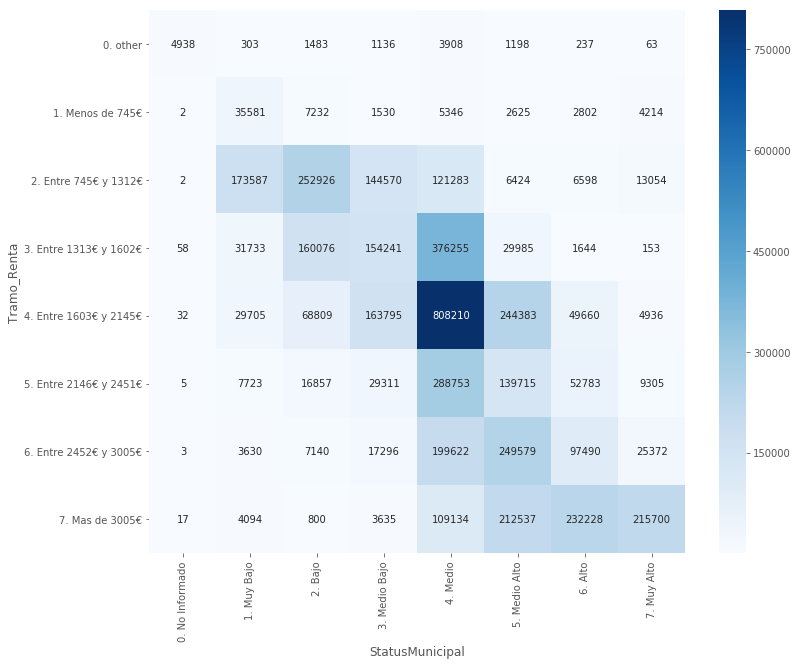

In [104]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 10))
sns.heatmap(df_pivoted, annot=True, fmt=".0f",cmap="Blues")


# Aggregate Customer

Now is the time to create a customer level analytical table as far as we want to model households. Please, notice that for AMDOCS stack, NUM_CLIENTE could be considered as a household identifier

In [ ]:
feats_gnv_voice_mou= [c for c in amdocs_ids_load.columns if (('GNV_hour' in c) & (('MOU') in c))]
feats_gnv_voice_NOC= [c for c in amdocs_ids_load.columns if (('GNV_hour' in c) & (('Num_Of_Calls') in c))]

feats_gnv_total_data_mb= [c for c in amdocs_ids_load.columns if (('GNV_hour' in c)& (('Data_Volume_MB') in c))]
feats_gnv_data_mb_chatzero= [c for c in amdocs_ids_load.columns if (('GNV_hour' in c)& (('Chat_Zero_Data_Volume_MB') in c))]
feats_gnv_data_mb_maps= [c for c in amdocs_ids_load.columns if (('GNV_hour' in c)& (('Maps_Pass_Data_Volume_MB') in c))]
feats_gnv_data_mb_masmegas= [c for c in amdocs_ids_load.columns if (('GNV_hour' in c)& (('MasMegas_Data_Volume_MB') in c))]
feats_gnv_data_mb_music= [c for c in amdocs_ids_load.columns if (('GNV_hour' in c)& (('Music_Pass_Data_Volume_MB') in c))]
feats_gnv_data_mb_regular= [c for c in amdocs_ids_load.columns if (('GNV_hour' in c)& (('RegularData_Data_Volume_MB') in c))]
feats_gnv_data_mb_social= [c for c in amdocs_ids_load.columns if (('GNV_hour' in c)& (('Social_Pass_Data_Volume_MB') in c))]
feats_gnv_data_mb_videoHD= [c for c in amdocs_ids_load.columns if (('GNV_hour' in c)& (('VideoHD_Pass_Data_Volume_MB') in c))]
feats_gnv_data_mb_video= [c for c in amdocs_ids_load.columns if (('GNV_hour' in c)& (('Video_Pass_Data_Volume_MB') in c))]

#NEW 20190404
#feats_gnv_type_usage_mou=[c for c in amdocs_ids_load.columns if (('GNV_Type_Voice' in c)& (('MOU') in c))]
#feats_gnv_type_usage_NOC= [c for c in amdocs_ids_load.columns if (('GNV_Type_Voice' in c)& (('Num_Of_Calls') in c))]

feats_custagg=['fbb_services_nc', 'fixed_services_nc', 'mobile_services_nc', 'prepaid_services_nc', 'tv_services_nc']


feats_billing=[c for c in amdocs_ids_load.columns if (('Bill_N2' in c) & ('Amount_To_Pay' in c))]

feats_netscout_data=[c for c in amdocs_ids_load.columns if (('NS_APPS' in c) & ('data_mb' in c))]
feats_netscout_days=[c for c in amdocs_ids_load.columns if (('NS_APPS' in c) & ('days' in c))]

feats_billing

In [ ]:
exprs  = [sql_sum(coalesce(sql_round(x,2),lit(0))).alias(x) for x in feats_gnv_voice_mou]
exprs  += [sql_sum(coalesce(sql_round(x,2),lit(0))).alias(x) for x in feats_gnv_total_data_mb]
#exprs += [f_max  (coalesce(sql_round(x,2),lit(0))).alias(x+'_max') for x in feats_gnv_voice_mou]
exprs += [f_max  (coalesce(sql_round(x,2),lit(0))).alias(x) for x in feats_custagg]
exprs += [f_max  (coalesce(sql_round(x,2),lit(0))).alias(x) for x in feats_billing]

exprs += [sql_sum  (coalesce(sql_round(x,2),lit(0))).alias(x) for x in feats_netscout_data]
exprs += [sql_sum  (coalesce(sql_round(x,2),lit(0))).alias(x) for x in feats_netscout_days]

#exprs += [sql_sum  (coalesce(sql_round(x,2),lit(0))).alias(x) for x in feats_gnv_voice_mou]

amdocs_ids_agg_df_tmp1=(amdocs_ids_load
 .groupBy('NUM_CLIENTE')
 .agg(*exprs)
 )


amdocs_ids_agg_df=(amdocs_ids_agg_df_tmp1
                  .withColumn('total_mou',sum_horizontal(feats_gnv_voice_mou))
                  .withColumn('total_data_mb',sum_horizontal(feats_gnv_total_data_mb))
                  .withColumn('total_data_mb_chatzero',sum_horizontal(feats_gnv_data_mb_chatzero))
                  .withColumn('total_data_mb_mapspass',sum_horizontal(feats_gnv_data_mb_maps))
                  .withColumn('total_data_mb_masmegas',sum_horizontal(feats_gnv_data_mb_masmegas))
                  .withColumn('total_data_mb_musicpass',sum_horizontal(feats_gnv_data_mb_music))
                  .withColumn('total_data_mb_socialpass',sum_horizontal(feats_gnv_data_mb_social))
                  .withColumn('total_data_mb_videohdpass',sum_horizontal(feats_gnv_data_mb_videoHD))
                  .withColumn('total_data_mb_videopass',sum_horizontal(feats_gnv_data_mb_video))
                  #.drop(*feats_gnv_voice_mou)
                  #.drop(*feats_gnv_total_data_mb)
 
                  )


In [107]:
#print ('Customer total: '+str(amdocs_ids_agg_df.count())+' , with unique values: '+str(amdocs_ids_agg_df.agg(countDistinct('NUM_CLIENTE')).show()))
#print ('Surveys total: '+str(master_surveys_df.count())+' , with unique values: '+str(master_surveys_df.agg(countDistinct('NUM_CLIENTE')).show()))
#print ('Axesor total: '+str(df_axesor_study.count())+' , with unique values: '+str(df_axesor_study.agg(countDistinct('NUM_CLIENTE')).show()))
#
#print ('Customer total: '+amdocs_ids_agg_df.count()+' , with unique values: '+amdocs_ids_agg_df.agg(countDistinct('NUM_CLIENTE')))

amdocs_ids_agg_df.printSchema()

root
 |-- NUM_CLIENTE: string (nullable = true)
 |-- GNV_hour_0_W_MOU: double (nullable = true)
 |-- GNV_hour_0_WE_MOU: double (nullable = true)
 |-- GNV_hour_10_W_MOU: double (nullable = true)
 |-- GNV_hour_10_WE_MOU: double (nullable = true)
 |-- GNV_hour_11_W_MOU: double (nullable = true)
 |-- GNV_hour_11_WE_MOU: double (nullable = true)
 |-- GNV_hour_12_W_MOU: double (nullable = true)
 |-- GNV_hour_12_WE_MOU: double (nullable = true)
 |-- GNV_hour_13_W_MOU: double (nullable = true)
 |-- GNV_hour_13_WE_MOU: double (nullable = true)
 |-- GNV_hour_14_W_MOU: double (nullable = true)
 |-- GNV_hour_14_WE_MOU: double (nullable = true)
 |-- GNV_hour_15_W_MOU: double (nullable = true)
 |-- GNV_hour_15_WE_MOU: double (nullable = true)
 |-- GNV_hour_16_W_MOU: double (nullable = true)
 |-- GNV_hour_16_WE_MOU: double (nullable = true)
 |-- GNV_hour_17_W_MOU: double (nullable = true)
 |-- GNV_hour_17_WE_MOU: double (nullable = true)
 |-- GNV_hour_18_W_MOU: double (nullable = true)
 |-- GNV_hour_

# Join aggregated AIDS with label col

In [108]:
df_tmp1=(amdocs_ids_agg_df
        .join(master_surveys_df,'NUM_CLIENTE','leftouter')
        .join(df_axesor_study, 'NUM_CLIENTE' ,'leftouter')
        .repartition(200))

In [109]:
df_tmp1.groupBy('FLAG_CHILDREN').count().show()

+-------------+-------+
|FLAG_CHILDREN|  count|
+-------------+-------+
|         null|6073703|
|            1|   1750|
|            0|   1265|
+-------------+-------+



In [110]:
#df_tmp1.printSchema()

# 1. Children at Home

In a first step, we will develop a model identifying households with children
Initial sample contains about 5K surveys matched with our customer base

In [111]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('/var/SP/data/home/avazq108/New_general_model_trainer')
from new_general_model_trainer import GeneralModelTrainer
from model_outputs import ModelParameters


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [112]:
ignore_cols=['NUM_CLIENTE','CAMPO1','NUM_CLIENTE_deanon','NIF_CLIENTE','nif_ID_Cliente','amdocs_ID_Cliente','CHILDREN_GREATER_AGE','FLAG_CHILDREN_OVER18','ident_AXESOR']

modeler=GeneralModelTrainer(df_tmp1,'FLAG_CHILDREN',ignore_cols=ignore_cols, debug=False)


label_col is FLAG_CHILDREN of type int
[Thu Nov  7 11:47:17 2019] Label FLAG_CHILDREN is numeric, so no need of converting or indexing it


There are 9 ignore columns
There are 744 columns in given DataFrame
There are 10 int columns
There are 597 double columns
There are 126 bigint columns
There are 11 string columns


There are 5 categorical columns
There are 729 numeric columns


In [113]:
#modeler.set_debug(False)

In [114]:
modeler.relevelCategoricalVars() #se crea un diccionario que se puede cargar en ejecuciones posteriores

[Thu Nov  7 11:47:20 2019] Counting number of distinct values in categorical variables ...


Processing Tramo_Renta: 100%|██████████| 5/5 [07:58<00:00, 93.88s/variable]     

[Thu Nov  7 11:55:18 2019] Counting number of distinct values in categorical variables ... done
[Thu Nov  7 11:55:18 2019] Detected 0 constant columns: []
[Thu Nov  7 11:55:18 2019] Writing cols_to_relevel to disk cols_to_relevel-20191107115518.txt
[Thu Nov  7 11:55:18 2019] Releveling 0 categorical variables with more than 32 levels, and dropping constant columns: []
[Thu Nov  7 11:55:18 2019] Releveled  0 categorical variables with more than 32 levels, and dropped constant columns


<new_general_model_trainer.GeneralModelTrainer instance at 0x7f109ff4bd40>

In [115]:
modeler.generateFeaturesVector()

[Thu Nov  7 11:55:18 2019] Counting NULLs in label FLAG_CHILDREN ...
[Thu Nov  7 11:57:24 2019] Counting NULLs in label FLAG_CHILDREN ... 6073702
[Thu Nov  7 11:57:24 2019] Using column 'pred' to separate NULLs ...
[Thu Nov  7 11:58:57 2019] Using column 'pred' to separate NULLs ... done
[Thu Nov  7 11:58:57 2019] Indexing categorical features ...


Processing Tramo_Renta: 100%|██████████| 5/5 [07:50<00:00, 96.10s/variable]     

[Thu Nov  7 12:06:48 2019] Indexing categorical features ... done


[Thu Nov  7 12:06:48 2019] Assembling 734 features ...
[Thu Nov  7 12:06:56 2019] Assembling 734 features ... done


<new_general_model_trainer.GeneralModelTrainer instance at 0x7f109ff4bd40>

In [116]:
modeler.minMaxScale()

[Thu Nov  7 12:06:56 2019] Applying minMaxScaler to range [0.000000, 1.000000] ...
[Thu Nov  7 12:15:06 2019] Applying minMaxScaler to range [0.000000, 1.000000] ... done


<new_general_model_trainer.GeneralModelTrainer instance at 0x7f109ff4bd40>

In [117]:
modeler.split_train_test()

[Thu Nov  7 12:15:07 2019] Found column "pred". Removing prediction rows for training
[Thu Nov  7 12:15:08 2019] Splitting data set into train(70%)/test(30%) ...
[Thu Nov  7 12:15:10 2019] Splitting data set into train(70%)/test(30%) ... done


<new_general_model_trainer.GeneralModelTrainer instance at 0x7f109ff4bd40>

In [118]:
modeler.train()

[Thu Nov  7 12:15:10 2019] Not found column "pred". Removing null rows for training
[Thu Nov  7 12:15:11 2019] Balancing train data ...
[Thu Nov  7 12:15:17 2019] Sampling DataFrame by column FLAG_CHILDREN_without_nulls with fractions: {0: 1.0, 1: 0.7306155075939249} ...
[Thu Nov  7 12:15:18 2019] Sampling DataFrame by column FLAG_CHILDREN_without_nulls with fractions: {0: 1.0, 1: 0.7306155075939249} ... done
[Thu Nov  7 12:15:18 2019] Caching train data ...
[Thu Nov  7 12:15:18 2019] Caching train data ... done
[Thu Nov  7 12:15:18 2019] Balancing test data ...
[Thu Nov  7 12:15:26 2019] Sampling DataFrame by column FLAG_CHILDREN_without_nulls with fractions: {0: 1.0, 1: 0.7014028056112225} ...
[Thu Nov  7 12:15:27 2019] Sampling DataFrame by column FLAG_CHILDREN_without_nulls with fractions: {0: 1.0, 1: 0.7014028056112225} ... done
[Thu Nov  7 12:15:27 2019] Caching test data ...
[Thu Nov  7 12:15:28 2019] Caching test data ... done
[Thu Nov  7 12:15:30 2019] Added new stage: RandomF

<new_general_model_trainer.GeneralModelTrainer instance at 0x7f109ff4bd40>

In [119]:
modeler.evaluate()

Model Performance Metrics using (balanced) train data
[Thu Nov  7 12:16:17 2019] Predicting data ...
[Thu Nov  7 12:16:20 2019] Using element -1 as positive class
[Thu Nov  7 12:16:21 2019] Predicting data ... done
[Thu Nov  7 12:16:21 2019] Converting evaluation_predictions to Pandas ...
[Thu Nov  7 12:16:31 2019] Converting evaluation_predictions to Pandas ... done
matthews_corrcoef: 0.7263182195293157
f2_score: 0.829283752376928
jaccard_similarity_score: 0.8607123870281765
precision_score: 0.9075144508670521
classification_report:
              precision    recall  f1-score   support

           0       0.82      0.91      0.86       914
           1       0.91      0.81      0.86       967

   micro avg       0.86      0.86      0.86      1881
   macro avg       0.86      0.86      0.86      1881
weighted avg       0.87      0.86      0.86      1881

average_precision_score: 0.9414145105644858
confusion_matrix:
[[834, 80], [182, 785]]
hinge_loss: 0.8478722577079821
f1_score: 0.8569

<new_general_model_trainer.GeneralModelTrainer instance at 0x7f109ff4bd40>

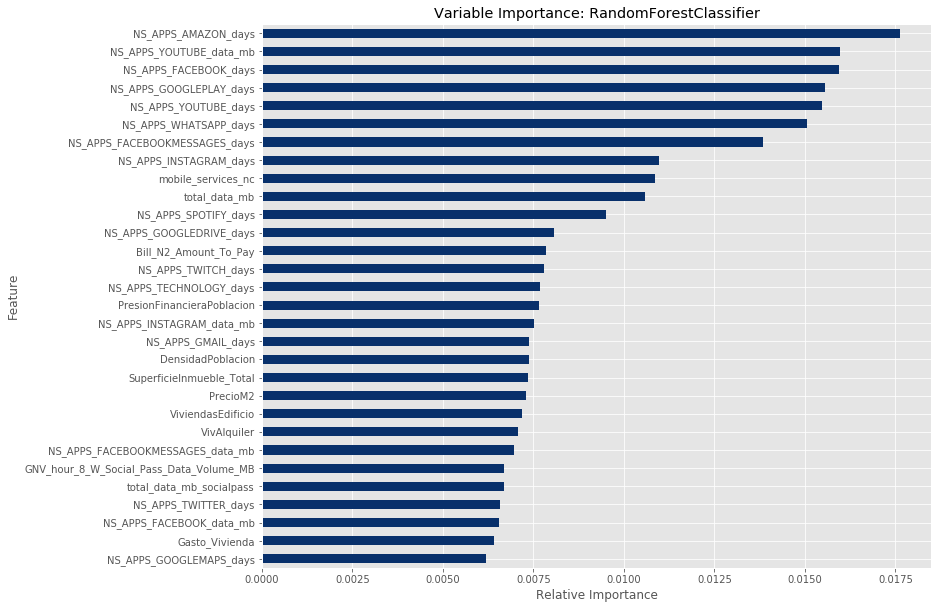

In [120]:
#model=modeler.get_model()
modeler.varimp_plot()

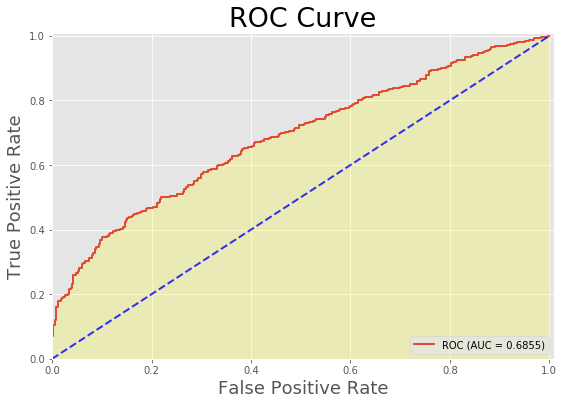

In [121]:
modeler.roc_plot(modeler.metrics_unbalanced_test ,figsize=(9,6))

In [122]:
modeler.predict()
results_tmp1=modeler.predictions
#results['NUM_CLIENTE','rawPrediction','probability','prediction','score'].show()

results=(results_tmp1['NUM_CLIENTE','prediction','score']
         .withColumnRenamed('prediction','prediction_flag_children')
         .withColumnRenamed('score','score_flag_children')
        )

[Thu Nov  7 12:16:58 2019] Selecting rows to predict
[Thu Nov  7 12:16:58 2019] Found column "pred". Selecting prediction rows
[Thu Nov  7 12:16:59 2019] Predicting data ...
[Thu Nov  7 12:17:02 2019] Using last element as positive class
[Thu Nov  7 12:17:03 2019] Predicting data ... done


In [123]:
results.groupBy('prediction_flag_children').count().show()

+------------------------+-------+
|prediction_flag_children|  count|
+------------------------+-------+
|                     0.0|2005112|
|                     1.0|4071606|
+------------------------+-------+



In [124]:
evaluation_metrics_balanced_test_kids_home = modeler.metrics_balanced_test

evaluation_metrics_unbalanced_test_kids_home = modeler.metrics_unbalanced_test

evaluation_metrics_train_kids_home = modeler.metrics_train

## Model Outputs ad hoc para este sub-modelo.

In [125]:
import time, datetime

## OJO! Esto hay que cambiarlo en función de la entrega a realizar.
closing_day = '20191031'
current_timestamp = datetime.datetime.now()
executed_at = current_timestamp.strftime('%Y-%m-%d %H:%M:%S')
analysis_month_M = datetime.datetime.strptime(closing_day, "%Y%m%d")

In [126]:
level = 'client_id'

model_name = 'hh_segmentation_children_at_home'

path_model_detail = 'model_name=' + model_name \
                            + '/year=' + str(current_timestamp.year) \
                            + '/month=' + str(current_timestamp.month) \
                            + '/day=0'

In [127]:
model_params_kids_home = {
    'algorithm': modeler.model.stages[0].getParam,
    'maxdepth': modeler.model.stages[0]._java_obj.getMaxDepth(),
    'maxbins': modeler.model.stages[0]._java_obj.getMaxBins(),
    'minInstancesPerNode': modeler.model.stages[0]._java_obj.getMinInstancesPerNode(),
    'numTrees': modeler.model.stages[0]._java_obj.getNumTrees(),
    'subsamplingRate': modeler.model.stages[0]._java_obj.getSubsamplingRate(),
    'seed': modeler.model.stages[0]._java_obj.getSeed()
}

In [128]:
path_model_outputs_base = '/data/attributes/vf_es/model_outputs/'
path_model_outputs_scores = path_model_outputs_base + 'model_scores/' + path_model_detail
path_model_outputs_params = path_model_outputs_base + 'model_parameters/' + path_model_detail

In [129]:
path_model_works_base = '/user/avazq108/models_prod/'
path_model_works_model = path_model_works_base + 'model_definition/' + path_model_detail
path_model_works_metrics = path_model_works_base + 'model_metrics/' + path_model_detail

- Parameters:

In [130]:
target = "Predicting if there are children at home (1) or not (0);"
model_path = path_model_works_model.replace(',', ';')
metrics_path = path_model_works_metrics.replace(',', ';')
metrics_train = str(evaluation_metrics_train_kids_home).replace(',', ';')
metrics_test = str(evaluation_metrics_unbalanced_test_kids_home).replace(',', ';')
varimp = ';'.join(str(v) for v in modeler.varimp[['feature', 'relative_importance']].values.tolist()).replace(',', ';')
algorithm = str(model_params_kids_home).replace(',', ';')
author_login = 'avazq108'
scores_extra_info_headers = None
time = int(current_timestamp.strftime('%H%M%S'))

In [131]:
description = "Predicting if there is any child at home;"

In [132]:
import time as tm

end_time = tm.time()
time_of_execution = str(int(end_time - start_time))

In [133]:
extra_info = '{description:'+description+'; processing_time:'+time_of_execution+'}'

In [134]:
from pyspark.sql.types import *

fields = [StructField("executed_at", StringType(), True),
                  StructField("model_level", StringType(), True),
                  StructField("training_closing_date", StringType(), True),
                  StructField("target", StringType(), True),
                  StructField("model_path", StringType(), True),
                  StructField("metrics_path", StringType(), True),
                  StructField("metrics_train", StringType(), True),
                  StructField("metrics_test", StringType(), True),
                  StructField("varimp", StringType(), True),
                  StructField("algorithm", StringType(), True),
                  StructField("author_login", StringType(), True),
                  StructField("extra_info", StringType(), True),
                  StructField("scores_extra_info_headers", StringType(), True),
                  StructField("time", IntegerType(), True)
                  ]

In [135]:
schema = StructType(fields)

In [136]:
data = [[executed_at, level, closing_day, target, model_path, metrics_path, metrics_train,
                 metrics_test, varimp, algorithm, author_login, extra_info, scores_extra_info_headers, time]]

In [137]:
df_save_params = spark.createDataFrame(data, schema)

In [138]:
def saveDF(path, df, partitions):
    print('Saving started in: %s', path)
    spark.conf.set("spark.sql.sources.partitionOverwriteMode","dynamic")
    df.repartition(partitions).write.mode('append').format('parquet').save(path)
    print('Saving finished!')

In [139]:
saveDF(path_model_outputs_params, df_save_params, 1)

('Saving started in: %s', '/data/attributes/vf_es/model_outputs/model_parameters/model_name=hh_segmentation_children_at_home/year=2019/month=11/day=0')
Saving finished!


- Model scores:

In [140]:
df_save_scores = (results
                        .withColumn('executed_at', lit(executed_at).cast(StringType()))
                        .withColumn('model_executed_at', lit(executed_at).cast(StringType()))
                        .withColumn('predict_closing_date', lit(closing_day).cast(StringType()))
                        .withColumn('msisdn', lit(None).cast(StringType()))
                        .withColumn('client_id', col('NUM_CLIENTE').cast(StringType()))
                        .withColumn('nif', lit(None).cast(StringType()))
                        .withColumn('model_output', lit(None).cast(StringType()))
                        .withColumn('scoring', col('score_flag_children').cast(FloatType()))
                        .withColumn('prediction', col('prediction_flag_children').cast(StringType()))
                        .withColumn('extra_info', lit(None).cast(StringType()))
                        .withColumn('time', lit(time).cast(IntegerType()))
                        .select('executed_at', 'model_executed_at', 'predict_closing_date', 'msisdn'
                                       , 'client_id', 'nif', 'model_output', 'scoring', 'prediction'
                                       , 'extra_info', 'time')
                            )

In [141]:
saveDF(path_model_outputs_scores, df_save_scores, 1)

('Saving started in: %s', '/data/attributes/vf_es/model_outputs/model_scores/model_name=hh_segmentation_children_at_home/year=2019/month=11/day=0')
Saving finished!


# 2. Any of them over 18 years old
In a second stage, we will infer households with any child over 18 years old. 
We will use only households predicted as "with children" in the previous step

In [142]:
df_tmp2=(df_tmp1
        .join(results,'NUM_CLIENTE','leftouter')
         .where((col('FLAG_CHILDREN')==1)|(col('prediction_flag_children')==1))
        )

In [143]:
df_tmp2.groupBy('FLAG_CHILDREN','FLAG_CHILDREN_OVER18','prediction_flag_children').count().orderBy('FLAG_CHILDREN','FLAG_CHILDREN_OVER18','prediction_flag_children').show(200)

+-------------+--------------------+------------------------+-------+
|FLAG_CHILDREN|FLAG_CHILDREN_OVER18|prediction_flag_children|  count|
+-------------+--------------------+------------------------+-------+
|         null|                null|                     1.0|4070208|
|            0|                null|                     1.0|    179|
|            1|                   0|                     0.0|    241|
|            1|                   0|                     1.0|    657|
|            1|                   1|                     0.0|    290|
|            1|                   1|                     1.0|    562|
+-------------+--------------------+------------------------+-------+



In [144]:
# Preparation of second model

In [145]:
ignore_cols=['NUM_CLIENTE','CAMPO1','NUM_CLIENTE_deanon','NIF_CLIENTE','nif_ID_Cliente','amdocs_ID_Cliente','CHILDREN_GREATER_AGE','FLAG_CHILDREN','ident_AXESOR','prediction_flag_children','score_flag_children']

modeler_over18=GeneralModelTrainer(df_tmp1,'FLAG_CHILDREN_OVER18',ignore_cols=ignore_cols, debug=False)

label_col is FLAG_CHILDREN_OVER18 of type int
[Thu Nov  7 12:36:34 2019] Label FLAG_CHILDREN_OVER18 is numeric, so no need of converting or indexing it


There are 11 ignore columns
There are 744 columns in given DataFrame
There are 10 int columns
There are 597 double columns
There are 126 bigint columns
There are 11 string columns


There are 5 categorical columns
There are 729 numeric columns


In [146]:
modeler_over18.relevelCategoricalVars()

[Thu Nov  7 12:36:37 2019] Counting number of distinct values in categorical variables ...


Processing Tramo_Renta: 100%|██████████| 5/5 [06:25<00:00, 76.32s/variable]     

[Thu Nov  7 12:43:03 2019] Counting number of distinct values in categorical variables ... done
[Thu Nov  7 12:43:03 2019] Detected 0 constant columns: []
[Thu Nov  7 12:43:03 2019] Writing cols_to_relevel to disk cols_to_relevel-20191107124303.txt
[Thu Nov  7 12:43:03 2019] Releveling 0 categorical variables with more than 32 levels, and dropping constant columns: []
[Thu Nov  7 12:43:03 2019] Releveled  0 categorical variables with more than 32 levels, and dropped constant columns


<new_general_model_trainer.GeneralModelTrainer instance at 0x7f109ff6e290>

In [147]:
modeler_over18.generateFeaturesVector()

[Thu Nov  7 12:43:03 2019] Counting NULLs in label FLAG_CHILDREN_OVER18 ...
[Thu Nov  7 12:44:33 2019] Counting NULLs in label FLAG_CHILDREN_OVER18 ... 6074968
[Thu Nov  7 12:44:34 2019] Using column 'pred' to separate NULLs ...
[Thu Nov  7 12:46:00 2019] Using column 'pred' to separate NULLs ... done
[Thu Nov  7 12:46:00 2019] Indexing categorical features ...


Processing Tramo_Renta: 100%|██████████| 5/5 [10:37<00:00, 124.28s/variable]    

[Thu Nov  7 12:56:38 2019] Indexing categorical features ... done


[Thu Nov  7 12:56:38 2019] Assembling 734 features ...
[Thu Nov  7 12:56:46 2019] Assembling 734 features ... done


<new_general_model_trainer.GeneralModelTrainer instance at 0x7f109ff6e290>

In [148]:
modeler_over18.minMaxScale()

[Thu Nov  7 12:56:46 2019] Applying minMaxScaler to range [0.000000, 1.000000] ...
[Thu Nov  7 13:08:57 2019] Applying minMaxScaler to range [0.000000, 1.000000] ... done


<new_general_model_trainer.GeneralModelTrainer instance at 0x7f109ff6e290>

In [149]:
modeler_over18.split_train_test()

[Thu Nov  7 13:08:59 2019] Found column "pred". Removing prediction rows for training
[Thu Nov  7 13:09:00 2019] Splitting data set into train(70%)/test(30%) ...
[Thu Nov  7 13:09:02 2019] Splitting data set into train(70%)/test(30%) ... done


<new_general_model_trainer.GeneralModelTrainer instance at 0x7f109ff6e290>

In [150]:
modeler_over18.train()

[Thu Nov  7 13:09:02 2019] Not found column "pred". Removing null rows for training
[Thu Nov  7 13:09:03 2019] Balancing train data ...
[Thu Nov  7 13:09:09 2019] Sampling DataFrame by column FLAG_CHILDREN_OVER18_without_nulls with fractions: {0: 0.9511041009463722, 1: 1.0} ...
[Thu Nov  7 13:09:10 2019] Sampling DataFrame by column FLAG_CHILDREN_OVER18_without_nulls with fractions: {0: 0.9511041009463722, 1: 1.0} ... done
[Thu Nov  7 13:09:10 2019] Caching train data ...
[Thu Nov  7 13:09:10 2019] Caching train data ... done
[Thu Nov  7 13:09:10 2019] Balancing test data ...
[Thu Nov  7 13:09:16 2019] Sampling DataFrame by column FLAG_CHILDREN_OVER18_without_nulls with fractions: {0: 0.9431818181818182, 1: 1.0} ...
[Thu Nov  7 13:09:17 2019] Sampling DataFrame by column FLAG_CHILDREN_OVER18_without_nulls with fractions: {0: 0.9431818181818182, 1: 1.0} ... done
[Thu Nov  7 13:09:17 2019] Caching test data ...
[Thu Nov  7 13:09:17 2019] Caching test data ... done
[Thu Nov  7 13:09:19 20

<new_general_model_trainer.GeneralModelTrainer instance at 0x7f109ff6e290>

In [151]:
modeler_over18.evaluate()

Model Performance Metrics using (balanced) train data
[Thu Nov  7 13:10:11 2019] Predicting data ...
[Thu Nov  7 13:10:14 2019] Using element -1 as positive class
[Thu Nov  7 13:10:15 2019] Predicting data ... done
[Thu Nov  7 13:10:15 2019] Converting evaluation_predictions to Pandas ...
[Thu Nov  7 13:10:23 2019] Converting evaluation_predictions to Pandas ... done
matthews_corrcoef: 0.8461397578057971
f2_score: 0.9324546952224052
jaccard_similarity_score: 0.922824302134647
precision_score: 0.9085072231139647
classification_report:
              precision    recall  f1-score   support

           0       0.94      0.91      0.92       615
           1       0.91      0.94      0.92       603

   micro avg       0.92      0.92      0.92      1218
   macro avg       0.92      0.92      0.92      1218
weighted avg       0.92      0.92      0.92      1218

average_precision_score: 0.9840510704256324
confusion_matrix:
[[558, 57], [37, 566]]
hinge_loss: 0.881983198311137
f1_score: 0.923327

<new_general_model_trainer.GeneralModelTrainer instance at 0x7f109ff6e290>

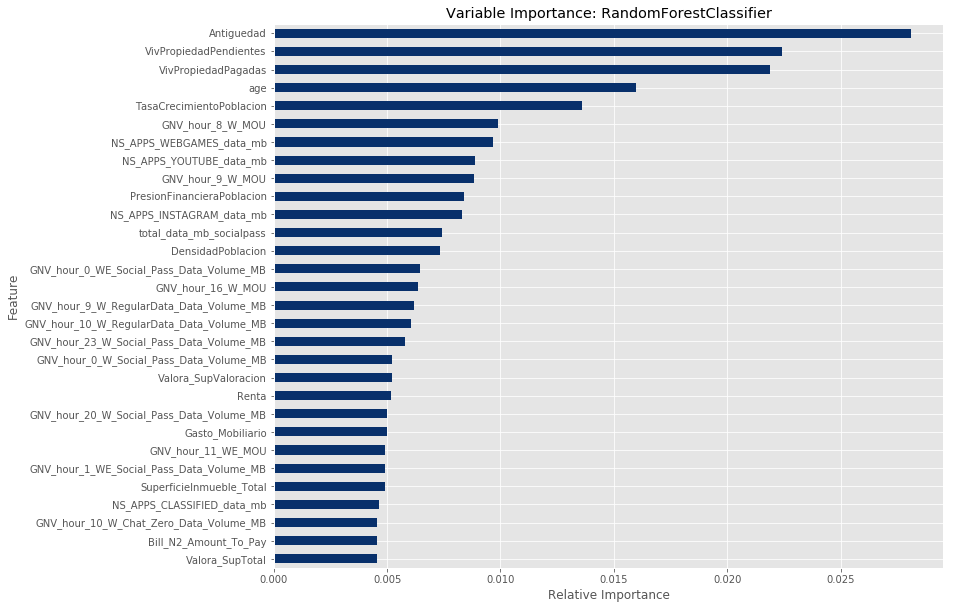

In [152]:
modeler_over18.varimp_plot()

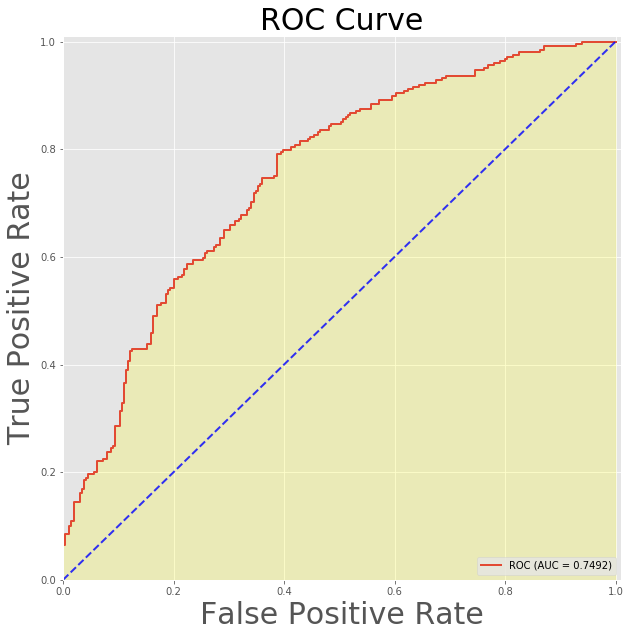

In [153]:
modeler_over18.roc_plot(modeler_over18.metrics_unbalanced_test,figsize=(10,10))

In [154]:
modeler_over18.predict()
results_over18_tmp1=modeler_over18.predictions
#results_over18['NUM_CLIENTE','rawPrediction','probability','prediction','score'].show()

results_over18=(results_over18_tmp1['NUM_CLIENTE','prediction','score']
         .withColumnRenamed('prediction','prediction_over18')
         .withColumnRenamed('score','score_over18')
        )

[Thu Nov  7 13:10:50 2019] Selecting rows to predict
[Thu Nov  7 13:10:50 2019] Found column "pred". Selecting prediction rows
[Thu Nov  7 13:10:51 2019] Predicting data ...
[Thu Nov  7 13:10:54 2019] Using last element as positive class
[Thu Nov  7 13:10:55 2019] Predicting data ... done


In [156]:
evaluation_metrics_balanced_test_over18 = modeler_over18.metrics_balanced_test

evaluation_metrics_unbalanced_test_over18 = modeler_over18.metrics_unbalanced_test

evaluation_metrics_train_over18 = modeler_over18.metrics_train

## Creamos un Model Outputs *ad hoc* para este sub-modelo.

In [157]:
import time, datetime

## OJO! Esto hay que cambiarlo en función de la entrega a realizar.
closing_day = '20191031'
current_timestamp = datetime.datetime.now()
executed_at = current_timestamp.strftime('%Y-%m-%d %H:%M:%S')
analysis_month_M = datetime.datetime.strptime(closing_day, "%Y%m%d")

In [158]:
level = 'client_id'

model_name = 'hh_segmentation_age_kids_over_18'

path_model_detail = 'model_name=' + model_name \
                            + '/year=' + str(current_timestamp.year) \
                            + '/month=' + str(current_timestamp.month) \
                            + '/day=0'

In [159]:
model_params_over18 = {
    'algorithm': modeler_over18.model.stages[0].getParam,
    'maxdepth': modeler_over18.model.stages[0]._java_obj.getMaxDepth(),
    'maxbins': modeler_over18.model.stages[0]._java_obj.getMaxBins(),
    'minInstancesPerNode': modeler_over18.model.stages[0]._java_obj.getMinInstancesPerNode(),
    'numTrees': modeler_over18.model.stages[0]._java_obj.getNumTrees(),
    'subsamplingRate': modeler_over18.model.stages[0]._java_obj.getSubsamplingRate(),
    'seed': modeler_over18.model.stages[0]._java_obj.getSeed()
}

In [160]:
path_model_outputs_base = '/data/attributes/vf_es/model_outputs/'
path_model_outputs_scores = path_model_outputs_base + 'model_scores/' + path_model_detail
path_model_outputs_params = path_model_outputs_base + 'model_parameters/' + path_model_detail

In [161]:
path_model_works_base = '/user/avazq108/models_prod/'
path_model_works_model = path_model_works_base + 'model_definition/' + path_model_detail
path_model_works_metrics = path_model_works_base + 'model_metrics/' + path_model_detail

- Model parameters:

In [162]:
target = "Predicting if any of the kids at home is over 18 years old or not;"
model_path = path_model_works_model.replace(',', ';')
metrics_path = path_model_works_metrics.replace(',', ';')
metrics_train = str(evaluation_metrics_train_over18).replace(',', ';')
metrics_test = str(evaluation_metrics_unbalanced_test_over18).replace(',', ';')
varimp = ';'.join(str(v) for v in modeler_over18.varimp[['feature', 'relative_importance']].values.tolist()).replace(',', ';')
algorithm = str(model_params_over18).replace(',', ';')
author_login = 'avazq108'
scores_extra_info_headers = None
time = int(current_timestamp.strftime('%H%M%S'))

In [163]:
description = "Predicting if any of the kids at home is over 18 years old or not;"

In [164]:
import time as tm

end_time = tm.time()
time_of_execution = str(int(end_time - start_time))

In [165]:
extra_info = '{description:'+description+'; processing_time:'+time_of_execution+'}'

In [166]:
from pyspark.sql.types import *

fields = [StructField("executed_at", StringType(), True),
                  StructField("model_level", StringType(), True),
                  StructField("training_closing_date", StringType(), True),
                  StructField("target", StringType(), True),
                  StructField("model_path", StringType(), True),
                  StructField("metrics_path", StringType(), True),
                  StructField("metrics_train", StringType(), True),
                  StructField("metrics_test", StringType(), True),
                  StructField("varimp", StringType(), True),
                  StructField("algorithm", StringType(), True),
                  StructField("author_login", StringType(), True),
                  StructField("extra_info", StringType(), True),
                  StructField("scores_extra_info_headers", StringType(), True),
                  StructField("time", IntegerType(), True)
                  ]

In [167]:
schema = StructType(fields)

In [168]:
data = [[executed_at, level, closing_day, target, model_path, metrics_path, metrics_train,
                 metrics_test, varimp, algorithm, author_login, extra_info, scores_extra_info_headers, time]]

In [169]:
df_save_params = spark.createDataFrame(data, schema)

In [170]:
def saveDF(path, df, partitions):
    print('Saving started in: %s', path)
    spark.conf.set("spark.sql.sources.partitionOverwriteMode","dynamic")
    df.repartition(partitions).write.mode('append').format('parquet').save(path)
    print('Saving finished!')

In [171]:
saveDF(path_model_outputs_params, df_save_params, 1)

('Saving started in: %s', '/data/attributes/vf_es/model_outputs/model_parameters/model_name=hh_segmentation_age_kids_over_18/year=2019/month=11/day=0')
Saving finished!


- Model outputs:

In [172]:
df_save_scores = (results_over18
                        .withColumn('executed_at', lit(executed_at).cast(StringType()))
                        .withColumn('model_executed_at', lit(executed_at).cast(StringType()))
                        .withColumn('predict_closing_date', lit(closing_day).cast(StringType()))
                        .withColumn('msisdn', lit(None).cast(StringType()))
                        .withColumn('client_id', col('NUM_CLIENTE').cast(StringType()))
                        .withColumn('nif', lit(None).cast(StringType()))
                        .withColumn('model_output', lit(None).cast(StringType()))
                        .withColumn('scoring', col('score_over18').cast(FloatType()))
                        .withColumn('prediction', col('prediction_over18').cast(StringType()))
                        .withColumn('extra_info', lit(None).cast(StringType()))
                        .withColumn('time', lit(time).cast(IntegerType()))
                        .select('executed_at', 'model_executed_at', 'predict_closing_date', 'msisdn'
                                       , 'client_id', 'nif', 'model_output', 'scoring', 'prediction'
                                       , 'extra_info', 'time')
                            )

In [173]:
saveDF(path_model_outputs_scores, df_save_scores, 1)

('Saving started in: %s', '/data/attributes/vf_es/model_outputs/model_scores/model_name=hh_segmentation_age_kids_over_18/year=2019/month=11/day=0')
Saving finished!


# 3. Age over 55
In a third step, we will be infering the age of the head of family mainly focused on determined if it is over or under 55 years old

In [174]:
(amdocs_ids_load
 .dropDuplicates()
 .withColumn('FECHA_NACI',substring(col('FECHA_NACI'),1,4))
 .withColumn('type',when((col('FECHA_NACI')==1753)&(col('birth_date')==1753),'both uninformed'  )
                   .when((col('FECHA_NACI')==1753)&(col('birth_date')>1753),'birth_date_informed'  )
                   .when((col('FECHA_NACI')>1753)&(col('birth_date')==1753),'FECHA_NACI_informed'  )
                   .when((col('FECHA_NACI')>1753)&(col('birth_date')>1753)&(col('birth_date')==col('FECHA_NACI')),'both_informed_equal'  )
                   .when((col('FECHA_NACI')>1753)&(col('birth_date')>1753)&(col('birth_date')<>col('FECHA_NACI')),'both_informed_different'  )
            )
 .groupBy('type')
 .count()
 .orderBy(desc('count'))
 ).show(200,False)

+-----------------------+--------+
|type                   |count   |
+-----------------------+--------+
|birth_date_informed    |10080820|
|both uninformed        |3666728 |
|both_informed_equal    |1020766 |
|both_informed_different|15452   |
|null                   |15      |
+-----------------------+--------+



In [175]:
df_age_tmp1=(df_tmp1
            .withColumn('AGE_OVER_55',when(col('age').between(0,54),0)
                                     .when(col('age').between(55,100),1)
                                     .otherwise(None))
            )

In [176]:
df_age_tmp1.groupBy('age').count().show()

+-----+------+
|  age| count|
+-----+------+
|  148|     2|
| -946|     2|
|  243|     4|
| -975|     1|
|   31| 85757|
|   85| 21329|
|  251|     3|
|  137|    11|
|   65| 50540|
|   53| 83786|
|  255|     2|
|  133|    14|
|   78| 30284|
|-2693|   381|
|  -13|    19|
|  -33|     1|
|  -20|    28|
|  108|    40|
|  155|     4|
|   34|105554|
+-----+------+
only showing top 20 rows



In [177]:
ignore_cols_over55=['NUM_CLIENTE','CAMPO1','NUM_CLIENTE_deanon','NIF_CLIENTE','nif_ID_Cliente','amdocs_ID_Cliente','CHILDREN_GREATER_AGE','FLAG_CHILDREN','FLAG_CHILDREN_OVER18','ident_AXESOR','age','birth_date']
modeler_over55=GeneralModelTrainer(df_age_tmp1,'AGE_OVER_55',ignore_cols=ignore_cols_over55, debug=False)

label_col is AGE_OVER_55 of type int
[Thu Nov  7 13:50:17 2019] Label AGE_OVER_55 is numeric, so no need of converting or indexing it


There are 12 ignore columns
There are 745 columns in given DataFrame
There are 11 int columns
There are 597 double columns
There are 126 bigint columns
There are 11 string columns


There are 5 categorical columns
There are 728 numeric columns


In [178]:
modeler_over55.relevelCategoricalVars()

[Thu Nov  7 13:50:19 2019] Counting number of distinct values in categorical variables ...


Processing Tramo_Renta: 100%|██████████| 5/5 [08:14<00:00, 100.24s/variable]    

[Thu Nov  7 13:58:34 2019] Counting number of distinct values in categorical variables ... done
[Thu Nov  7 13:58:34 2019] Detected 0 constant columns: []
[Thu Nov  7 13:58:34 2019] Writing cols_to_relevel to disk cols_to_relevel-20191107135834.txt
[Thu Nov  7 13:58:34 2019] Releveling 0 categorical variables with more than 32 levels, and dropping constant columns: []
[Thu Nov  7 13:58:34 2019] Releveled  0 categorical variables with more than 32 levels, and dropped constant columns


<new_general_model_trainer.GeneralModelTrainer instance at 0x7f109ff97ab8>

In [179]:
modeler_over55.generateFeaturesVector()

[Thu Nov  7 13:58:34 2019] Counting NULLs in label AGE_OVER_55 ...
[Thu Nov  7 14:00:52 2019] Counting NULLs in label AGE_OVER_55 ... 1433002
[Thu Nov  7 14:00:52 2019] Using column 'pred' to separate NULLs ...
[Thu Nov  7 14:02:16 2019] Using column 'pred' to separate NULLs ... done
[Thu Nov  7 14:02:16 2019] Indexing categorical features ...


Processing Tramo_Renta: 100%|██████████| 5/5 [09:45<00:00, 114.04s/variable]     

[Thu Nov  7 14:12:02 2019] Indexing categorical features ... done


[Thu Nov  7 14:12:02 2019] Assembling 733 features ...
[Thu Nov  7 14:12:09 2019] Assembling 733 features ... done


<new_general_model_trainer.GeneralModelTrainer instance at 0x7f109ff97ab8>

In [180]:
modeler_over55.minMaxScale()

[Thu Nov  7 14:12:09 2019] Applying minMaxScaler to range [0.000000, 1.000000] ...
[Thu Nov  7 14:18:21 2019] Applying minMaxScaler to range [0.000000, 1.000000] ... done


<new_general_model_trainer.GeneralModelTrainer instance at 0x7f109ff97ab8>

In [181]:
modeler_over55.split_train_test()

[Thu Nov  7 14:18:22 2019] Found column "pred". Removing prediction rows for training
[Thu Nov  7 14:18:24 2019] Splitting data set into train(70%)/test(30%) ...
[Thu Nov  7 14:18:25 2019] Splitting data set into train(70%)/test(30%) ... done


<new_general_model_trainer.GeneralModelTrainer instance at 0x7f109ff97ab8>

In [182]:
modeler_over55.train()

[Thu Nov  7 14:18:25 2019] Not found column "pred". Removing null rows for training
[Thu Nov  7 14:18:27 2019] Balancing train data ...
[Thu Nov  7 14:19:04 2019] Sampling DataFrame by column AGE_OVER_55_without_nulls with fractions: {0: 0.5032647503110826, 1: 1.0} ...
[Thu Nov  7 14:19:05 2019] Sampling DataFrame by column AGE_OVER_55_without_nulls with fractions: {0: 0.5032647503110826, 1: 1.0} ... done
[Thu Nov  7 14:19:05 2019] Caching train data ...
[Thu Nov  7 14:19:05 2019] Caching train data ... done
[Thu Nov  7 14:19:05 2019] Balancing test data ...
[Thu Nov  7 14:19:48 2019] Sampling DataFrame by column AGE_OVER_55_without_nulls with fractions: {0: 0.5023498254770097, 1: 1.0} ...
[Thu Nov  7 14:19:48 2019] Sampling DataFrame by column AGE_OVER_55_without_nulls with fractions: {0: 0.5023498254770097, 1: 1.0} ... done
[Thu Nov  7 14:19:48 2019] Caching test data ...
[Thu Nov  7 14:19:49 2019] Caching test data ... done
[Thu Nov  7 14:19:51 2019] Added new stage: RandomForestCla

<new_general_model_trainer.GeneralModelTrainer instance at 0x7f109ff97ab8>

In [183]:
modeler_over55.evaluate()

Model Performance Metrics using (balanced) train data
[Thu Nov  7 14:35:03 2019] Predicting data ...
[Thu Nov  7 14:35:05 2019] Using element -1 as positive class
[Thu Nov  7 14:35:07 2019] Predicting data ... done
[Thu Nov  7 14:35:07 2019] Converting evaluation_predictions to Pandas ...
[Thu Nov  7 14:38:48 2019] Converting evaluation_predictions to Pandas ... done
matthews_corrcoef: 0.43285329358004476
f2_score: 0.640316551458721
jaccard_similarity_score: 0.7123468563628275
precision_score: 0.7632352773696858
classification_report:
              precision    recall  f1-score   support

           0       0.68      0.81      0.74   1089170
           1       0.76      0.62      0.68   1088769

   micro avg       0.71      0.71      0.71   2177939
   macro avg       0.72      0.71      0.71   2177939
weighted avg       0.72      0.71      0.71   2177939

average_precision_score: 0.7979571327193377
confusion_matrix:
[[881274, 207896], [418595, 670174]]
hinge_loss: 0.8964836861209017
f1

<new_general_model_trainer.GeneralModelTrainer instance at 0x7f109ff97ab8>

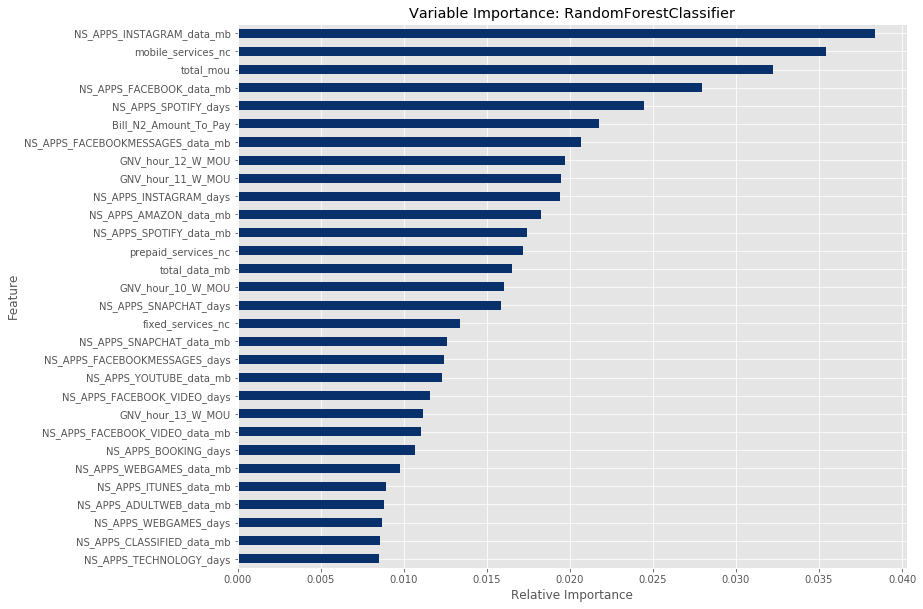

In [184]:
modeler_over55.varimp_plot()

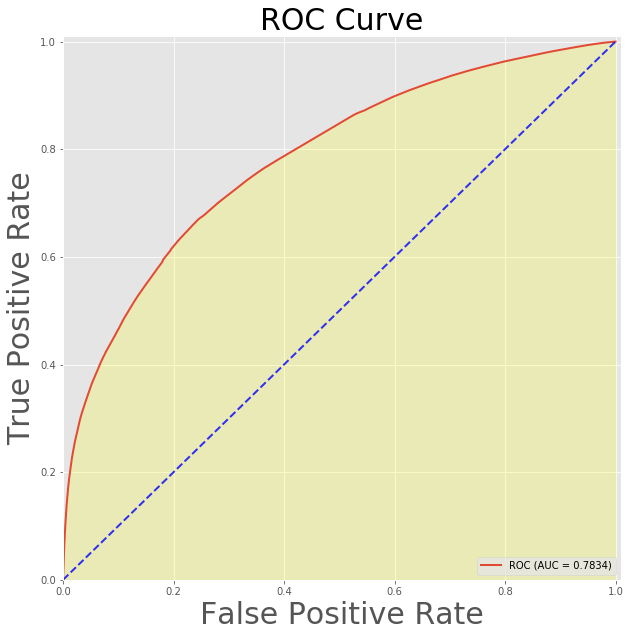

In [185]:
modeler_over55.roc_plot(modeler_over55.metrics_unbalanced_test ,figsize=(10,10))

In [186]:
modeler_over55.predict()
results_over55_tmp1=modeler_over55.predictions

results_over55=(results_over55_tmp1['NUM_CLIENTE','prediction','score']
         .withColumnRenamed('prediction','prediction_over55')
         .withColumnRenamed('score','score_over55')
        ).cache()

[Thu Nov  7 14:45:59 2019] Selecting rows to predict
[Thu Nov  7 14:45:59 2019] Found column "pred". Selecting prediction rows
[Thu Nov  7 14:46:00 2019] Predicting data ...
[Thu Nov  7 14:46:02 2019] Using last element as positive class
[Thu Nov  7 14:46:04 2019] Predicting data ... done


In [187]:
evaluation_metrics_balanced_test_over55 = modeler_over55.metrics_balanced_test

evaluation_metrics_unbalanced_test_over55 = modeler_over55.metrics_unbalanced_test

evaluation_metrics_train_over55 = modeler_over55.metrics_train

## Preparamos un `Model Outputs` *ad hoc* para este submodelo:

In [188]:
import time, datetime

## OJO! Esto hay que cambiarlo en función de la entrega a realizar.
closing_day = '20191031'
current_timestamp = datetime.datetime.now()
executed_at = current_timestamp.strftime('%Y-%m-%d %H:%M:%S')
analysis_month_M = datetime.datetime.strptime(closing_day, "%Y%m%d")

In [189]:
level = 'client_id'

model_name = 'hh_segmentation_age_over_55'

path_model_detail = 'model_name=' + model_name \
                            + '/year=' + str(current_timestamp.year) \
                            + '/month=' + str(current_timestamp.month) \
                            + '/day=0'

In [190]:
model_params_over55 = {
    'algorithm': modeler_over55.model.stages[0].getParam,
    'maxdepth': modeler_over55.model.stages[0]._java_obj.getMaxDepth(),
    'maxbins': modeler_over55.model.stages[0]._java_obj.getMaxBins(),
    'minInstancesPerNode': modeler_over55.model.stages[0]._java_obj.getMinInstancesPerNode(),
    'numTrees': modeler_over55.model.stages[0]._java_obj.getNumTrees(),
    'subsamplingRate': modeler_over55.model.stages[0]._java_obj.getSubsamplingRate(),
    'seed': modeler_over55.model.stages[0]._java_obj.getSeed()
}

In [191]:
path_model_outputs_base = '/data/attributes/vf_es/model_outputs/'
path_model_outputs_scores = path_model_outputs_base + 'model_scores/' + path_model_detail
path_model_outputs_params = path_model_outputs_base + 'model_parameters/' + path_model_detail

In [192]:
path_model_works_base = '/user/avazq108/models_prod/'
path_model_works_model = path_model_works_base + 'model_definition/' + path_model_detail
path_model_works_metrics = path_model_works_base + 'model_metrics/' + path_model_detail

- Model parameters:

In [193]:
target = "Predicting whether the head of the family is over 55 years old or not;"
model_path = path_model_works_model.replace(',', ';')
metrics_path = path_model_works_metrics.replace(',', ';')
metrics_train = str(evaluation_metrics_train_over55).replace(',', ';')
metrics_test = str(evaluation_metrics_unbalanced_test_over55).replace(',', ';')
varimp = ';'.join(str(v) for v in modeler_over55.varimp[['feature', 'relative_importance']].values.tolist()).replace(',', ';')
algorithm = str(model_params_over55).replace(',', ';')
author_login = 'avazq108'
scores_extra_info_headers = None
time = int(current_timestamp.strftime('%H%M%S'))

In [194]:
description = 'Predicting whether the head of the family is over 55 years old or not;'

In [195]:
import time as tm

end_time = tm.time()
time_of_execution = str(int(end_time - start_time))

In [196]:
extra_info = '{description:'+description+'; processing_time:'+time_of_execution+'}'

In [197]:
from pyspark.sql.types import *

fields = [StructField("executed_at", StringType(), True),
                  StructField("model_level", StringType(), True),
                  StructField("training_closing_date", StringType(), True),
                  StructField("target", StringType(), True),
                  StructField("model_path", StringType(), True),
                  StructField("metrics_path", StringType(), True),
                  StructField("metrics_train", StringType(), True),
                  StructField("metrics_test", StringType(), True),
                  StructField("varimp", StringType(), True),
                  StructField("algorithm", StringType(), True),
                  StructField("author_login", StringType(), True),
                  StructField("extra_info", StringType(), True),
                  StructField("scores_extra_info_headers", StringType(), True),
                  StructField("time", IntegerType(), True)
                  ]

In [198]:
schema = StructType(fields)

In [199]:
data = [[executed_at, level, closing_day, target, model_path, metrics_path, metrics_train,
                 metrics_test, varimp, algorithm, author_login, extra_info, scores_extra_info_headers, time]]

In [200]:
df_save_params = spark.createDataFrame(data, schema)

In [201]:
def saveDF(path, df, partitions):
    print('Saving started in: %s', path)
    spark.conf.set("spark.sql.sources.partitionOverwriteMode","dynamic")
    df.repartition(partitions).write.mode('append').format('parquet').save(path)
    print('Saving finished!')

In [202]:
saveDF(path_model_outputs_params, df_save_params, 1)

('Saving started in: %s', '/data/attributes/vf_es/model_outputs/model_parameters/model_name=hh_segmentation_age_over_55/year=2019/month=11/day=0')
Saving finished!


- Model outputs:

In [203]:
df_save_scores = (results_over55
                        .withColumn('executed_at', lit(executed_at).cast(StringType()))
                        .withColumn('model_executed_at', lit(executed_at).cast(StringType()))
                        .withColumn('predict_closing_date', lit(closing_day).cast(StringType()))
                        .withColumn('msisdn', lit(None).cast(StringType()))
                        .withColumn('client_id', col('NUM_CLIENTE').cast(StringType()))
                        .withColumn('nif', lit(None).cast(StringType()))
                        .withColumn('model_output', lit(None).cast(StringType()))
                        .withColumn('scoring', col('score_over55').cast(FloatType()))
                        .withColumn('prediction', col('prediction_over55').cast(StringType()))
                        .withColumn('extra_info', lit(None).cast(StringType()))
                        .withColumn('time', lit(time).cast(IntegerType()))
                        .select('executed_at', 'model_executed_at', 'predict_closing_date', 'msisdn'
                                       , 'client_id', 'nif', 'model_output', 'scoring', 'prediction'
                                       , 'extra_info', 'time')
                            )

In [204]:
saveDF(path_model_outputs_scores, df_save_scores, 1)

('Saving started in: %s', '/data/attributes/vf_es/model_outputs/model_scores/model_name=hh_segmentation_age_over_55/year=2019/month=11/day=0')
Saving finished!


# Finally: Everything together

In [ ]:
#customer_master.printSchema()

In [205]:
df_total_tmp1=(df_tmp1['NUM_CLIENTE','fbb_services_nc','fixed_services_nc','mobile_services_nc','prepaid_services_nc','tv_services_nc','CHILDREN_GREATER_AGE','FLAG_CHILDREN','FLAG_CHILDREN_OVER18','age']
              .withColumn('AGE_OVER_55',when(col('age').between(0,54),0)
                           .when(col('age').between(55,100),1)
                           .otherwise(None))
              .join(results,'NUM_CLIENTE','leftouter')
              .join(results_over18,'NUM_CLIENTE','leftouter')
              .join(results_over55,'NUM_CLIENTE','leftouter')
              )


In [206]:
df_total_tmp2=(df_total_tmp1
               .withColumn('FINAL_FLAG_CHILDREN',coalesce('FLAG_CHILDREN','prediction_flag_children'))
               .withColumn('FINAL_FLAG_CHILDREN_OVER18',coalesce('FLAG_CHILDREN_OVER18','prediction_over18'))
               .withColumn('FINAL_FLAG_OVER55',coalesce('AGE_OVER_55','prediction_over55'))
              )



In [226]:
#Status

devices_df=(amdocs_ids_load
            .groupBy('NUM_CLIENTE')
            .agg(sql_sum(when(col('Device_N1_device_type')=='Tablet',1).otherwise(0)).alias('num_tablet'))
            )

results_tmp1=(df_total_tmp2
               .drop(*['EDAD','birth_date'])
               .join(df_axesor_study,'NUM_CLIENTE','leftouter')
               .join(devices_df,'NUM_CLIENTE','leftouter')
               .withColumn('Tramo_Renta_num',substring(col('Tramo_Renta'),0,1))
              #BROAD SEGMENTS
               .withColumn('broad_segment',when( (col('FINAL_FLAG_CHILDREN')==1) & (col('FINAL_FLAG_CHILDREN_OVER18')==1),lit('2. OPTIMAL VALUE'))
                                          .when( (col('FINAL_FLAG_CHILDREN')==1) & (col('FINAL_FLAG_CHILDREN_OVER18')==0),lit('3. WE WANT IT ALL'))
                                          .when( (col('FINAL_FLAG_CHILDREN')==0) & (col('FINAL_FLAG_OVER55')==0),lit('1. CONNECTION SEARCHERS'))
                                          .when( (col('FINAL_FLAG_CHILDREN')==0) & (col('FINAL_FLAG_OVER55')==1),lit('4. MAKE IT EASY'))
                                          .otherwise(None))
               #NICHE SEGMENTS
               .withColumn('niche_1_conn_search',when(col('tv_services_nc')>=1,lit('1. UNLIMITED CONNECTION'))
                                                .when(col('tv_services_nc')==0,lit('2. JUST A CONNECTION'))
                                                .otherwise(None))
               .withColumn('niche_2_opt_value',when(col('tv_services_nc')>=1,lit('1. TV HUNTERS'))
                                              .when((col('tv_services_nc')==0)&(col('fbb_services_nc')==0),lit('2. DOWNSIZERS'))
                                              .when((col('tv_services_nc')==0)&(col('fbb_services_nc')==1),lit('2. DOWNSIZERS'))
                                              .otherwise(None))
               .withColumn('niche_3_we_want_it_all',when(col('Tramo_Renta_num')>3,'1. FULL EQUIPE')
                                                   .when((col('Tramo_Renta_num')<=3) & (col('num_tablet')==0),'2. BABY CONTENT SEEKERS')
                                                   .when((col('Tramo_Renta_num')<=3) & (col('num_tablet')>=1) & (col('tv_services_nc')>=1),'1. FULL EQUIPE')
                                                   .when((col('Tramo_Renta_num')<=3) & (col('num_tablet')>=1) & (col('tv_services_nc')==0),'2. BABY CONTENT SEEKERS')
                                                   .otherwise(None))
               .withColumn('niche_4_make_it_easy',when(col('fbb_services_nc')>=1,lit('1. UP TO DATE'))
                                                   .when((col('fbb_services_nc')==0) & (col('Tramo_Renta_num')>=3) ,lit('1. UP TO DATE'))
                                                   .when((col('fbb_services_nc')==0) & (col('Tramo_Renta_num')<3) ,lit('2. OLD FASHION'))
                                                   .otherwise(None))
               .withColumn('niche_segment',when(col('broad_segment')=='1. CONNECTION SEARCHERS',col('niche_1_conn_search'))
                                          .when(col('broad_segment')=='2. OPTIMAL VALUE',col('niche_2_opt_value'))
                                          .when(col('broad_segment')=='3. WE WANT IT ALL',col('niche_3_we_want_it_all'))
                                          .when(col('broad_segment')=='4. MAKE IT EASY',col('niche_4_make_it_easy'))
                                          .otherwise(None))
              )

In [266]:
from pyspark.sql.functions import concat, col, lit

results_tmp2 = results_tmp1.withColumn("extra_info", concat(lit("{CHILDREN_AT_HOME: "), col('FINAL_FLAG_CHILDREN'), lit("; CHILDREN_OVER_18: "), col("FINAL_FLAG_CHILDREN_OVER18"),
                                                            lit("; HEAD_OVER_55: "), col("FINAL_FLAG_OVER55"), lit("; TV_SERVICES: "), col("tv_services_nc"),
                                                            lit("; FBB_SERVICES: "), col("fbb_services_nc"), lit("; NUM_TRAMO_RENTA: "), col("Tramo_Renta_num"), 
                                                            lit("; NUM_TABLET: "), col("num_tablet"), lit("}")
                                                           )
                                      )

In [267]:
results_final = results_tmp2.withColumn("segment_and_subsegment", concat(lit('{BROAD_SEGMENT: '), col('broad_segment'),
                                                                         lit('; NICHE_SEGMENT: '), col('niche_segment'), 
                                                                         lit('}')
                                                                        )
                                       )

## Preparamos la salida para Model Outputs.

In [268]:
import time, datetime

## OJO! Esto hay que cambiarlo en función de la entrega a realizar.
closing_day = '20191031'
current_timestamp = datetime.datetime.now()
executed_at = current_timestamp.strftime('%Y-%m-%d %H:%M:%S')
analysis_month_M = datetime.datetime.strptime(closing_day, "%Y%m%d")

In [269]:
level = 'client_id'

model_name = 'hh_segmentation'

path_model_detail = 'model_name=' + model_name \
                            + '/year=' + str(current_timestamp.year) \
                            + '/month=' + str(current_timestamp.month) \
                            + '/day=0'

In [270]:
model_params_hh = {
    'algorithm': 'Decision rules'
}

In [271]:
path_model_outputs_base = '/data/attributes/vf_es/model_outputs/'
path_model_outputs_scores = path_model_outputs_base + 'model_scores/' + path_model_detail
path_model_outputs_params = path_model_outputs_base + 'model_parameters/' + path_model_detail

In [272]:
path_model_works_base = '/user/avazq108/models_prod/'
path_model_works_model = path_model_works_base + 'model_definition/' + path_model_detail
path_model_works_metrics = path_model_works_base + 'model_metrics/' + path_model_detail

- Model Parameters:

In [279]:
target = "Building the final household segmentation according to some decision rules."
model_path = path_model_works_model.replace(',', ';')
metrics_path = path_model_works_metrics.replace(',', ';')
metrics_train = None
metrics_test = None
varimp = ';'
algorithm = None
author_login = 'avazq108'
scores_extra_info_headers = None
time = int(current_timestamp.strftime('%H%M%S'))

In [254]:
description = 'Building the final household segmentation according to some decision rules.'

In [275]:
import time as tm

end_time = tm.time()
time_of_execution = str(int(end_time - start_time))

In [276]:
extra_info = '{description:'+description+'; processing_time:'+time_of_execution+'}'

In [277]:
from pyspark.sql.types import *

fields = [StructField("executed_at", StringType(), True),
                  StructField("model_level", StringType(), True),
                  StructField("training_closing_date", StringType(), True),
                  StructField("target", StringType(), True),
                  StructField("model_path", StringType(), True),
                  StructField("metrics_path", StringType(), True),
                  StructField("metrics_train", StringType(), True),
                  StructField("metrics_test", StringType(), True),
                  StructField("varimp", StringType(), True),
                  StructField("algorithm", StringType(), True),
                  StructField("author_login", StringType(), True),
                  StructField("extra_info", StringType(), True),
                  StructField("scores_extra_info_headers", StringType(), True),
                  StructField("time", IntegerType(), True)
                  ]

In [258]:
schema = StructType(fields)

In [259]:
data = [[executed_at, level, closing_day, target, model_path, metrics_path, metrics_train,
                 metrics_test, varimp, algorithm, author_login, extra_info, scores_extra_info_headers, time]]

In [260]:
df_save_params = spark.createDataFrame(data, schema)

In [261]:
def saveDF(path, df, partitions):
    print('Saving started in: %s', path)
    spark.conf.set("spark.sql.sources.partitionOverwriteMode","dynamic")
    df.repartition(partitions).write.mode('append').format('parquet').save(path)
    print('Saving finished!')

In [262]:
saveDF(path_model_outputs_params, df_save_params, 1)

('Saving started in: %s', '/data/attributes/vf_es/model_outputs/model_parameters/model_name=hh_segmentation/year=2019/month=11/day=0')
Saving finished!


- Model outputs:

In [281]:
df_save_scores = (results_final
                        .withColumn('executed_at', lit(executed_at).cast(StringType()))
                        .withColumn('model_executed_at', lit(executed_at).cast(StringType()))
                        .withColumn('predict_closing_date', lit(closing_day).cast(StringType()))
                        .withColumn('msisdn', lit(None).cast(StringType()))
                        .withColumn('client_id', col('NUM_CLIENTE').cast(StringType()))
                        .withColumn('nif', lit(None).cast(StringType()))
                        .withColumn('model_output', col('segment_and_subsegment').cast(StringType()))
                        .withColumn('scoring', lit(None).cast(FloatType()))
                        .withColumn('prediction', lit(None).cast(StringType()))
                        .withColumn('extra_info', col('extra_info').cast(StringType()))
                        .withColumn('time', lit(time).cast(IntegerType()))
                        .select('executed_at', 'model_executed_at', 'predict_closing_date', 'msisdn'
                                       , 'client_id', 'nif', 'model_output', 'scoring', 'prediction'
                                       , 'extra_info', 'time')
                                   )

In [282]:
test = df_save_scores.limit(10).toPandas()

In [293]:
saveDF(path_model_outputs_scores, df_save_scores, 1)

('Saving started in: %s', '/data/attributes/vf_es/model_outputs/model_scores/model_name=hh_segmentation/year=2019/month=11/day=0')
Saving finished!


# De momento, lo he dejado a nivel de NUM_CLIENTE. Si necesitan a otros niveles, lo cambiamos.

------

### A partir de aquí, se quedan los trozos viejos de código que prefiero no eliminar (por si las moscas...)

In [ ]:
#results_tmp1.groupBy('broad_segment').count().orderBy('broad_segment').show()
#results_tmp1.show(20,False)

In [ ]:
results_tmp1.groupBy('broad_segment','niche_segment').count().orderBy('broad_segment','niche_segment').show(20,False)

results_tmp1.agg(sql_sum(lit(1)).alias('regs'),countDistinct(col('NUM_CLIENTE')).alias('CLIS')).show()

#results_tmp1.where(col('niche_segment').isNotNull()).limit(200).toPandas()
results_tmp2=(results_tmp1
             .select('NUM_CLIENTE','prediction_flag_children','score_flag_children','prediction_over18','score_over18'
                    ,'prediction_over55','score_over55','broad_segment','niche_segment')
       )

In [ ]:
# Load Service IDS
hdfs_partition_path = ('year=' + str(int(ClosingDay[:4])) + 
                       '/month=' + str(int(ClosingDay[4:6])) + 
                       '/day=' + str(int(ClosingDay[6:8])))
hdfs_write_path_common = '/data/udf/vf_es/amdocs_ids/' 
path_service = hdfs_write_path_common +'service/'+hdfs_partition_path
serviceDF_load = (spark.read.load(path_service))
serviceDF_load.head()

In [ ]:
results_with_msisdn = \
(results_tmp2
 .join(serviceDF_load
       .select(col('NUM_CLIENTE'), col('msisdn')),
       'NUM_CLIENTE')
)

In [ ]:
results_with_msisdn.head()

In [ ]:
[results_tmp2.count(), results_with_msisdn.count()]

In [105]:
clean_result = \
(results_with_msisdn
 .where(col('msisdn').isNotNull())
 .where(length(col('msisdn')) == 9)
 .where(substring('msisdn',1,1) == 6)
# .limit(100).toPandas()
)

In [106]:
path_to_save_result='/data/attributes/vf_es/return_feed/hh_segmentation/'+hdfs_partition_path

saveDF(path_to_save_result, clean_result, 1)

[Mon Sep 16 08:58:03 2019] Saving started in: /data/attributes/vf_es/return_feed/hh_segmentation/year=2019/month=6/day=7


Py4JJavaError: An error occurred while calling o9952.save.
: java.io.IOException: Failed on local exception: java.io.IOException: Couldn't setup connection for adesant3@INTERNAL.VODAFONE.COM to vgddp349hr.dc.sedc.internal.vodafone.com/10.109.120.22:8020; Host Details : local host is: "vgddp387hr.dc.sedc.internal.vodafone.com/10.109.120.122"; destination host is: "vgddp349hr.dc.sedc.internal.vodafone.com":8020; 
	at org.apache.hadoop.net.NetUtils.wrapException(NetUtils.java:772)
	at org.apache.hadoop.ipc.Client.call(Client.java:1508)
	at org.apache.hadoop.ipc.Client.call(Client.java:1441)
	at org.apache.hadoop.ipc.ProtobufRpcEngine$Invoker.invoke(ProtobufRpcEngine.java:231)
	at com.sun.proxy.$Proxy13.getFileInfo(Unknown Source)
	at org.apache.hadoop.hdfs.protocolPB.ClientNamenodeProtocolTranslatorPB.getFileInfo(ClientNamenodeProtocolTranslatorPB.java:788)
	at sun.reflect.GeneratedMethodAccessor4.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at org.apache.hadoop.io.retry.RetryInvocationHandler.invokeMethod(RetryInvocationHandler.java:258)
	at org.apache.hadoop.io.retry.RetryInvocationHandler.invoke(RetryInvocationHandler.java:104)
	at com.sun.proxy.$Proxy14.getFileInfo(Unknown Source)
	at org.apache.hadoop.hdfs.DFSClient.getFileInfo(DFSClient.java:2168)
	at org.apache.hadoop.hdfs.DistributedFileSystem$20.doCall(DistributedFileSystem.java:1266)
	at org.apache.hadoop.hdfs.DistributedFileSystem$20.doCall(DistributedFileSystem.java:1262)
	at org.apache.hadoop.fs.FileSystemLinkResolver.resolve(FileSystemLinkResolver.java:81)
	at org.apache.hadoop.hdfs.DistributedFileSystem.getFileStatus(DistributedFileSystem.java:1262)
	at org.apache.hadoop.fs.FileSystem.exists(FileSystem.java:1418)
	at org.apache.spark.sql.execution.datasources.InsertIntoHadoopFsRelationCommand.run(InsertIntoHadoopFsRelationCommand.scala:92)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.sideEffectResult$lzycompute(commands.scala:104)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.sideEffectResult(commands.scala:102)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.doExecute(commands.scala:122)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:131)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:127)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$executeQuery$1.apply(SparkPlan.scala:155)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:152)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:127)
	at org.apache.spark.sql.execution.QueryExecution.toRdd$lzycompute(QueryExecution.scala:80)
	at org.apache.spark.sql.execution.QueryExecution.toRdd(QueryExecution.scala:80)
	at org.apache.spark.sql.DataFrameWriter$$anonfun$runCommand$1.apply(DataFrameWriter.scala:656)
	at org.apache.spark.sql.DataFrameWriter$$anonfun$runCommand$1.apply(DataFrameWriter.scala:656)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:77)
	at org.apache.spark.sql.DataFrameWriter.runCommand(DataFrameWriter.scala:656)
	at org.apache.spark.sql.DataFrameWriter.saveToV1Source(DataFrameWriter.scala:273)
	at org.apache.spark.sql.DataFrameWriter.save(DataFrameWriter.scala:267)
	at org.apache.spark.sql.DataFrameWriter.save(DataFrameWriter.scala:225)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: java.io.IOException: Couldn't setup connection for adesant3@INTERNAL.VODAFONE.COM to vgddp349hr.dc.sedc.internal.vodafone.com/10.109.120.22:8020
	at org.apache.hadoop.ipc.Client$Connection$1.run(Client.java:710)
	at java.security.AccessController.doPrivileged(Native Method)
	at javax.security.auth.Subject.doAs(Subject.java:422)
	at org.apache.hadoop.security.UserGroupInformation.doAs(UserGroupInformation.java:1924)
	at org.apache.hadoop.ipc.Client$Connection.handleSaslConnectionFailure(Client.java:681)
	at org.apache.hadoop.ipc.Client$Connection.setupIOstreams(Client.java:769)
	at org.apache.hadoop.ipc.Client$Connection.access$3000(Client.java:396)
	at org.apache.hadoop.ipc.Client.getConnection(Client.java:1557)
	at org.apache.hadoop.ipc.Client.call(Client.java:1480)
	... 46 more
Caused by: javax.security.sasl.SaslException: GSS initiate failed [Caused by GSSException: No valid credentials provided (Mechanism level: Failed to find any Kerberos tgt)]
	at com.sun.security.sasl.gsskerb.GssKrb5Client.evaluateChallenge(GssKrb5Client.java:211)
	at org.apache.hadoop.security.SaslRpcClient.saslConnect(SaslRpcClient.java:413)
	at org.apache.hadoop.ipc.Client$Connection.setupSaslConnection(Client.java:594)
	at org.apache.hadoop.ipc.Client$Connection.access$2000(Client.java:396)
	at org.apache.hadoop.ipc.Client$Connection$2.run(Client.java:761)
	at org.apache.hadoop.ipc.Client$Connection$2.run(Client.java:757)
	at java.security.AccessController.doPrivileged(Native Method)
	at javax.security.auth.Subject.doAs(Subject.java:422)
	at org.apache.hadoop.security.UserGroupInformation.doAs(UserGroupInformation.java:1924)
	at org.apache.hadoop.ipc.Client$Connection.setupIOstreams(Client.java:756)
	... 49 more
Caused by: GSSException: No valid credentials provided (Mechanism level: Failed to find any Kerberos tgt)
	at sun.security.jgss.krb5.Krb5InitCredential.getInstance(Krb5InitCredential.java:147)
	at sun.security.jgss.krb5.Krb5MechFactory.getCredentialElement(Krb5MechFactory.java:122)
	at sun.security.jgss.krb5.Krb5MechFactory.getMechanismContext(Krb5MechFactory.java:187)
	at sun.security.jgss.GSSManagerImpl.getMechanismContext(GSSManagerImpl.java:224)
	at sun.security.jgss.GSSContextImpl.initSecContext(GSSContextImpl.java:212)
	at sun.security.jgss.GSSContextImpl.initSecContext(GSSContextImpl.java:179)
	at com.sun.security.sasl.gsskerb.GssKrb5Client.evaluateChallenge(GssKrb5Client.java:192)
	... 58 more


In [98]:
path_to_save_result='/data/attributes/vf_es/return_feed/hh_segmentation/'+hdfs_partition_path
path_to_save_result

'/data/attributes/vf_es/return_feed/hh_segmentation/year=2019/month=6/day=7'

# END.

In [6]:
hdfs_partition_path = 'year=' + str(int(ClosingDay[:4])) + '/month=' + str(int(ClosingDay[4:6])) + '/day=' + str(int(ClosingDay[6:8]))
path_to_save='/data/attributes/vf_es/model_outputs/hh_segmentation/model/'+hdfs_partition_path
results_load = (spark.read.load(path_to_save))

In [7]:
results_load.head()

Row(NUM_CLIENTE=u'000066035', Cust_Agg_fbb_services_nc=1, Cust_Agg_fixed_services_nc=1, Cust_Agg_mobile_services_nc=2, Cust_Agg_prepaid_services_nc=0, Cust_Agg_tv_services_nc=1, CHILDREN_GREATER_AGE=None, FLAG_CHILDREN=None, FLAG_CHILDREN_OVER18=None, Cust_birth_date=1955, EDAD=64, AGE_OVER_55=1, prediction_flag_children=1.0, score_flag_children=0.5467185974121094, prediction_over18=0.0, score_over18=0.4610423743724823, prediction_over55=None, score_over55=None, FINAL_FLAG_CHILDREN=1.0, FINAL_FLAG_CHILDREN_OVER18=0.0, FINAL_FLAG_OVER55=1.0)

# End.

In [ ]:
spark.stop()